#HW2 - Transliteration



Please send this to dlnlp2023@mail.ru with subject "Surname_HW2"



Deadline: 16.01.2023



Харская Стефания Андреевна БКЛ212


In this task you are required to solve the transliteration problem of names from English to Russian. Transliteration of a string means writing this string using the alphabet of another language with the preservation of pronunciation, although not always.


## Basic algorithm

In [1]:
!wget https://github.com/s-nlp/filimdb_evaluation/raw/master/TRANSLIT.tar.gz

--2024-12-02 08:28:49--  https://github.com/s-nlp/filimdb_evaluation/raw/master/TRANSLIT.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/s-nlp/filimdb_evaluation/master/TRANSLIT.tar.gz [following]
--2024-12-02 08:28:49--  https://raw.githubusercontent.com/s-nlp/filimdb_evaluation/master/TRANSLIT.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1546458 (1.5M) [application/octet-stream]
Saving to: 'TRANSLIT.tar.gz'

TRANSLIT.tar.gz     100%[===================>]   1.47M  --.-KB/s    in 0.06s   

2024-12-02 08:28:49 (26.2 MB/s) - 'TRANSLIT.tar.gz' saved [1546458/1546458]



In [2]:
!gunzip TRANSLIT.tar.gz

In [3]:
!tar -xf TRANSLIT.tar

### Evaluation code

In [4]:
PREDS_FNAME = "preds_translit_baseline.tsv"
SCORED_PARTS = ('train', 'dev', 'train_small', 'dev_small', 'test')
TRANSLIT_PATH = "TRANSLIT"

In [5]:
import codecs
from pandas import read_csv
from typing import List


def load_dataset(data_dir_path=None, parts: List[str] = SCORED_PARTS):
    part2ixy = {}
    for part in parts:
        path = os.path.join(data_dir_path, f'{part}.tsv')
        with open(path, 'r', encoding='utf-8') as rf:
            # first line is a header of the corresponding columns
            lines = rf.readlines()[1:]
            col_count = len(lines[0].strip('\n').split('\t'))
            if col_count == 2:
                strings, transliterations = zip(
                    *list(map(lambda l: l.strip('\n').split('\t'), lines))
                )
            elif col_count == 1:
                strings = list(map(lambda l: l.strip('\n'), lines))
                transliterations = None
            else:
                raise ValueError("wrong amount of columns")

        part2ixy[part] = (
            [f'{part}/{i}' for i in range(len(strings))],
            strings, transliterations,
        )
    return part2ixy



def load_transliterations_only(data_dir_path=None, parts: List[str] = SCORED_PARTS):
    part2iy = {}
    for part in parts:
        path = os.path.join(data_dir_path, f'{part}.tsv')
        with open(path, 'r', encoding='utf-8') as rf:
            # first line is a header of the corresponding columns
            lines = rf.readlines()[1:]
            col_count = len(lines[0].strip('\n').split('\t'))
            n_lines = len(lines)
            if col_count == 2:
                transliterations = [l.strip('\n').split('\t')[1] for l in lines]
            elif col_count == 1:
                transliterations = None
            else:
                raise ValueError("Wrong amount of columns")
        part2iy[part] = (
            [f'{part}/{i}' for i in range(n_lines)],
            transliterations,
        )
    return part2iy



def save_preds(preds, preds_fname):
    """
    Save classifier predictions in format appropriate for scoring.
    """
    with codecs.open(preds_fname, 'w') as outp:
        for idx, preds in preds:
            print(idx, *preds, sep='\t', file=outp)
    print('Predictions saved to %s' % preds_fname)


def load_preds(preds_fname, top_k=1):
    """
    Load classifier predictions in format appropriate for scoring.
    """
    kwargs = {
        "filepath_or_buffer": preds_fname,
        "names": ["id", "pred"],
        "sep": '\t',
    }

    pred_ids = list(read_csv(**kwargs, usecols=["id"])["id"])
    pred_y = {
        pred_id: [y]
        for pred_id, y in zip(
            pred_ids, read_csv(**kwargs, usecols=["pred"])["pred"]
        )
    }

    for y in pred_y.values():
        assert len(y) == top_k

    return pred_ids, pred_y


def compute_hit_k(preds, k=10):
    raise NotImplementedError


def compute_mrr(preds):
    raise NotImplementedError


def compute_acc_1(preds, true):
    right_answers = 0
    bonus = 0
    for pred, y in zip(preds, true):
        if pred[0] == y:
            right_answers += 1
        elif pred[0] != pred[0] and y == 'нань':
            #print('Your test file contained empty string, skipping %f and %s' % (pred[0], y))
            bonus += 1 # bugfix: skip empty line in test
    return right_answers / (len(preds) - bonus)


def score(preds, true):
    assert len(preds) == len(true), 'inconsistent amount of predictions and ground truth answers'
    acc_1 = compute_acc_1(preds, true)
    return {'acc@1': acc_1}


def score_preds(preds_path, data_dir, parts=SCORED_PARTS):
    part2iy = load_transliterations_only(data_dir, parts=parts)
    pred_ids, pred_dict = load_preds(preds_path)
    # pred_dict = {i:y for i,y in zip(pred_ids, pred_y)}
    scores = {}
    for part, (true_ids, true_y) in part2iy.items():
        if true_y is None:
            print('no labels for %s set' % part)
            continue
        pred_y = [pred_dict[i] for i in true_ids]
        score_values = score(pred_y, true_y)
        acc_1 = score_values['acc@1']
        print('%s set accuracy@1: %.2f' % (part, acc_1))
        scores[part] = score_values
    return scores

## Transformer-based approach



To implement your algorithm, use the template code, which needs to be modified.



First, you need to add some details in the code of the Transformer architecture, implement the methods of the class `LrScheduler`, which is responsible for updating the learning rate during training.

Next, you need to select the hyperparameters for the model according to the proposed guide.

In [6]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 52.1 MB/s eta 0:00:00a 0:00:01


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import itertools as it
import collections as col
import random
import os
import copy
import json
import math
from tqdm import tqdm
import datetime, time


import copy
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import itertools as it
import collections as col
import random

import Levenshtein as le

### Load dataset and embeddings

In [8]:
def load_datasets(data_dir_path, parts):
    datasets = {}
    for part in parts:
        path = os.path.join(data_dir_path, f'{part}.tsv')
        datasets[part] = pd.read_csv(path, sep='\t', na_filter=False)
        print(f'Loaded {part} dataset, length: {len(datasets[part])}')
    return datasets

In [9]:
class TextEncoder:
    def __init__(self, load_dir_path=None):
        self.lang_keys = ['en', 'ru']
        self.directions = ['id2token', 'token2id']
        self.service_token_names = {
            'pad_token': '<pad>',
            'start_token': '<start>',
            'unk_token': '<unk>',
            'end_token': '<end>'
        }

        service_id2token = dict(enumerate(self.service_token_names.values()))
        service_token2id ={v:k for k,v in service_id2token.items()}
        self.service_vocabs = dict(zip(self.directions,
                                       [service_id2token, service_token2id]))

        if load_dir_path is None:
            self.vocabs = {}
            for lk in self.lang_keys:
                self.vocabs[lk] = copy.deepcopy(self.service_vocabs)
        else:
            self.vocabs = self.load_vocabs(load_dir_path)

    def load_vocabs(self, load_dir_path):
        vocabs = {}
        load_path = os.path.join(load_dir_path, 'vocabs')
        for lk in self.lang_keys:
            vocabs[lk] = {}
            for d in self.directions:
                columns = d.split('2')
                print(lk, d)
                df = pd.read_csv(os.path.join(load_path, f'{lk}_{d}'))
                vocabs[lk][d] = dict(zip(*[df[c] for c in columns]))
        return vocabs


    def save_vocabs(self, save_dir_path):
        save_path = os.path.join(save_dir_path, 'vocabs')
        os.makedirs(save_path, exist_ok=True)
        for lk in self.lang_keys:
            for d in self.directions:
                columns = d.split('2')
                pd.DataFrame(data=self.vocabs[lk][d].items(),
                    columns=columns).to_csv(os.path.join(save_path, f'{lk}_{d}'),
                                                index=False,
                                                sep=',')

    def make_vocabs(self, data_df):
        for lk in self.lang_keys:
            tokens = col.Counter(''.join(list(it.chain(*data_df[lk])))).keys()
            part_id2t = dict(enumerate(tokens, start=len(self.service_token_names)))
            part_t2id = {k:v for v,k in part_id2t.items()}
            part_vocabs = [part_id2t, part_t2id]
            for i in range(len(self.directions)):
                self.vocabs[lk][self.directions[i]].update(part_vocabs[i])

        self.src_vocab_size = len(self.vocabs['en']['id2token'])
        self.tgt_vocab_size = len(self.vocabs['ru']['id2token'])


    def frame(self, sample, start_token=None, end_token=None):
        if start_token is None:
            start_token=self.service_token_names['start_token']
        if end_token is None:
            end_token=self.service_token_names['end_token']
        return [start_token] + sample + [end_token]

    def token2id(self, samples, frame, lang_key):
        if frame:
            samples = list(map(self.frame, samples))
        vocab = self.vocabs[lang_key]['token2id']
        return list(map(lambda s:
                        [vocab[t] if t in vocab.keys() else vocab[self.service_token_names['unk_token']]
                         for t in s], samples))

    def unframe(self, sample, start_token=None, end_token=None):
        if start_token is None:
            start_token=self.service_vocabs['token2id'][self.service_token_names['start_token']]
        if end_token is None:
            end_token=self.service_vocabs['token2id'][self.service_token_names['end_token']]
        pad_token=self.service_vocabs['token2id'][self.service_token_names['pad_token']]
        return list(it.takewhile(lambda e: e != end_token and e != pad_token, sample[1:]))

    def id2token(self, samples, unframe, lang_key):
        if unframe:
            samples = list(map(self.unframe, samples))
        vocab = self.vocabs[lang_key]['id2token']
        return list(map(lambda s:
                        [vocab[idx] if idx in vocab.keys() else self.service_token_names['unk_token'] for idx in s], samples))


class TranslitData(torch_data.Dataset):
    def __init__(self, source_strings, target_strings,
                text_encoder):
        super(TranslitData, self).__init__()
        self.source_strings = source_strings
        self.text_encoder = text_encoder
        if target_strings is not None:
            assert len(source_strings) == len(target_strings)
            self.target_strings = target_strings
        else:
            self.target_strings = None

    def __len__(self):
        return len(self.source_strings)

    def __getitem__(self, idx):
        src_str = self.source_strings[idx]
        encoder_input = self.text_encoder.token2id([list(src_str)], frame=True, lang_key='en')[0]
        if self.target_strings is not None:
            tgt_str = self.target_strings[idx]
            tmp = self.text_encoder.token2id([list(tgt_str)], frame=True, lang_key='ru')[0]
            decoder_input = tmp[:-1]
            decoder_target = tmp[1:]
            return (encoder_input, decoder_input, decoder_target)
        else:
            return (encoder_input,)


class BatchSampler(torch_data.BatchSampler):
    def __init__(self, sampler, batch_size, drop_last, shuffle_each_epoch):
        super(BatchSampler, self).__init__(sampler, batch_size, drop_last)
        self.batches = []
        for b in super(BatchSampler, self).__iter__():
            self.batches.append(b)
        self.shuffle_each_epoch = shuffle_each_epoch
        if self.shuffle_each_epoch:
            random.shuffle(self.batches)
        self.index = 0
        print(f'Batches collected: {len(self.batches)}')

    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index == len(self.batches):
            if self.shuffle_each_epoch:
                random.shuffle(self.batches)
            raise StopIteration

        else:
            batch = self.batches[self.index]
            self.index += 1
            return batch



def collate_fn(batch_list):
    '''batch_list can store either 3 components:
        encoder_inputs, decoder_inputs, decoder_targets
        or single component: encoder_inputs'''
    components = list(zip(*batch_list))
    batch_tensors = []
    for data in components:
        max_len = max([len(sample) for sample in data])
        #print(f'Maximum length in batch = {max_len}')
        sample_tensors = [torch.tensor(s, requires_grad=False, dtype=torch.int64)
                         for s in data]
        batch_tensors.append(nn.utils.rnn.pad_sequence(
            sample_tensors,
            batch_first=True, padding_value=0))
    return tuple(batch_tensors)


def create_dataloader(source_strings, target_strings,
                      text_encoder, batch_size,
                      shuffle_batches_each_epoch):
    '''target_strings parameter can be None'''
    dataset = TranslitData(source_strings, target_strings,
                                text_encoder=text_encoder)
    seq_sampler = torch_data.SequentialSampler(dataset)
    batch_sampler = BatchSampler(seq_sampler, batch_size=batch_size,
                                drop_last=False,
                                shuffle_each_epoch=shuffle_batches_each_epoch)
    dataloader = torch_data.DataLoader(dataset,
                                       batch_sampler=batch_sampler,
                                       collate_fn=collate_fn)
    return dataloader

### Metric function

In [10]:
def compute_metrics(predicted_strings, target_strings, metrics):
    metric_values = {}
    for m in metrics:
        if m == 'acc@1':
            metric_values[m] = np.sum(predicted_strings == target_strings) / len(target_strings) #Добавила np.sum, так как просто sum выводил array, а не число
        elif m =='mean_ld@1':
            metric_values[m] =\
                np.mean(list(map(lambda e: le.distance(*e), zip(predicted_strings, target_strings))))
        else:
            raise ValueError(f'Unknown metric: {m}')
    return metric_values

###  Positional Encoding [1 Point]

As you remember, Transformer treats an input sequence of elements as a time series. Since the Encoder inside the Transformer simultaneously processes the entire input sequence, the information about the position of the element needs to be encoded inside its embedding, since it is not identified in any other way inside the model. That is why the PositionalEncoding layer is used, which sums embeddings with a vector of the same dimension.

Let the matrix of these vectors for each position of the time series be denoted as $PE$. Then the elements of the matrix are:



$$ PE_{(pos,2i)} = \sin{(pos/10000^{2i/d_{model}})}$$

$$ PE_{(pos,2i+1)} = \cos{(pos/10000^{2i/d_{model}})}$$



where $pos$ - is the position, $i$ - index of the component of the corresponging vector, $d_{model}$ - dimension of each vector. Thus, even components represent sine values, and odd ones represent cosine values with different arguments.



To run the test use the following function:



`test_positional_encoding()`



Make sure that there is no any `AssertionError`!


In [11]:
class Embedding(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super(Embedding, self).__init__()
        self.emb_layer = nn.Embedding(vocab_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, x):
        return self.emb_layer(x)


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, hidden_size, requires_grad=False)
        # TODO: implement your code here
        pos = torch.arange(0, max_len).unsqueeze(1) #здесь мы объявляем вектор позиций их у нас от 0 до нашей максимальной длинны
        div_term = torch.exp(torch.arange(0, hidden_size, 2) * -(math.log(torch.tensor(10000.0)) / hidden_size))
        #a^b = exp(b * log(a)), у нас в качетсве log(a) — логарифм от 10000, его надо
        #умножить на (2i/d_model). Соответственно 2i это torch.arange(0, hidden_size, 2). Знак минус для того, чтобы возвести в отрицательную степень.
        #по этой причине мы умножаем ниже, а не делим (как в формуле)
        pe[:, 0::2] = torch.sin(pos * div_term) #для чётных
        pe[:, 1::2] = torch.cos(pos * div_term) #для нечётных (это чтобы они не пересекались между собой)
        pe = pe.unsqueeze(0)
        # pe shape: (1, max_len, hidden_size)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: shape (batch size, sequence length, hidden size)
        x = x + self.pe[:, :x.size(1)]
        return x

In [12]:
def test_positional_encoding():
    pe = PositionalEncoding(max_len=3, hidden_size=4)
    res_1 = torch.tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
                           [ 0.8415,  0.5403,  0.0100,  0.9999],
                           [ 0.9093, -0.4161,  0.0200,  0.9998]]])
    # print(pe.pe - res_1)
    assert torch.all(torch.abs(pe.pe - res_1) < 1e-4).item()
    print('Test is passed!')

In [13]:
test_positional_encoding()

Test is passed!


### LayerNorm

In [14]:
class LayerNorm(nn.Module):
    "Layer Normalization layer"

    def __init__(self, hidden_size, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gain = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        #print(mean, std) #закоментировала, так как иначе был большой вывод и всё зависало
        return self.gain * (x - mean) / (std + self.eps) + self.bias

### SublayerConnection

In [15]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer normalization.
    """
    def __init__(self, hidden_size, dropout):
        super(SublayerConnection, self).__init__()
        self.layer_norm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return self.layer_norm(x + self.dropout(sublayer(x)))

def padding_mask(x, pad_idx=0):
    assert len(x.size()) >= 2
    return (x != pad_idx).unsqueeze(-2)


def look_ahead_mask(size):
    "Mask out the right context"
    attn_shape = (1, size, size)
    look_ahead_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(look_ahead_mask) == 0

def compositional_mask(x, pad_idx=0):
    pm = padding_mask(x, pad_idx=pad_idx)
    seq_length = x.size(-1)
    result_mask = pm & \
                  look_ahead_mask(seq_length).type_as(pm.data)
    return result_mask

### FeedForward [1 Point]

In [16]:
class FeedForward(nn.Module):
    def __init__(self, hidden_size, ff_hidden_size, dropout=0.1):
        super(FeedForward, self).__init__()
        # TODO: MAKE FEED FORWARD
        # It goes as linear -> RELU -> Dropout -> Linear
        self.pre_linear = nn.Linear(hidden_size, ff_hidden_size) #первый линейный слой увеличить размерность
        self.post_linear = nn.Linear(ff_hidden_size, hidden_size) #второй линейный слой возвращает к исходной размерности
        self.dropout = nn.Dropout(dropout) #обнуление

    def forward(self, x):
        # TODO: WRITE CORRECT RETURN
        #по схеме выше
        x = self.pre_linear(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.post_linear(x)
        return x

def clone_layer(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [17]:
def test_FF():
    ff = FeedForward(24, 256)
    assert(ff.pre_linear.weight.size() == (256, 24))
    assert(ff.post_linear.weight.size() == (24, 256))

    x = torch.rand(32, 24)
    out = ff(x)
    assert(out.size() == (32, 24))
    print('Test is passed!')

In [18]:
test_FF()

Test is passed!


###  MultiHeadAttention [1.5 Point]



Then you are required to implement `attention` method in the class  `MultiHeadAttention`. The MultiHeadAttention layer takes as input  query vectors, key and value vectors for each step of the sequence of matrices  Q,K,V correspondingly. Each key vector, value vector, and query vector is obtained as a result of linear projection using one of three trained vector parameter matrices from the previous layer. This semantics can be represented in the form of formulas:

$$
Attention(Q, K, V)=softmax\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V\\
$$



$$
MultiHead(Q, K, V) = Concat\left(head_1, ... , head_h\right) W^O\\
$$



$$
head_i=Attention\left(Q W_i^Q, K W_i^K, V W_i^V\right)\\
$$

$h$ - the number of attention heads - parallel sub-layers for Scaled Dot-Product Attention on a vector of smaller dimension ($d_{k} = d_{q} = d_{v} = d_{model} / h$).

The logic of  \texttt{MultiHeadAttention} is presented in the picture (from original  [paper](https://arxiv.org/abs/1706.03762)):



![](https://lilianweng.github.io/lil-log/assets/images/transformer.png)





Inside a method `attention` you are required to create a dropout layer from  MultiHeadAttention class constructor. Dropout layer is to be applied directly on the attention weights - the result of softmax operation. Value of drop probability  can be regulated in the train in the `model_config['dropout']['attention']`.



The correctness of implementation can be checked with

`test_multi_head_attention()`




In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, hidden_size, dropout=None):
        super(MultiHeadAttention, self).__init__()
        assert hidden_size % n_heads == 0
        self.head_hidden_size = hidden_size // n_heads
        self.n_heads = n_heads
        self.linears = clone_layer(nn.Linear(hidden_size, hidden_size), 4)
        self.attn_weights = None
        self.dropout = dropout
        if self.dropout is not None:
            self.dropout_layer = nn.Dropout(p=self.dropout)

    def attention(self, query, key, value, mask):
        """Compute 'Scaled Dot Product Attention'
            query, key and value tensors have the same shape:
                (batch size, number of heads, sequence length, head hidden size)
            mask shape: (batch size, 1, sequence length, sequence length)
                '1' dimension value will be broadcasted to number of heads inside your operations
            mask should be applied before using softmax to get attn_weights
        """
        ## attn_weights shape: (batch size, number of heads, sequence length, sequence length)
        ## output shape: (batch size, number of heads, sequence length, head hidden size)
        ## TODO: provide your implementation here
        ## don't forget to apply dropout to attn_weights if self.dropout is not None
        d_k = query.size(-1) #размерность
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) #формула, не забываем транспонировать K (в каждом батче своя штука будет происходить)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9) #если маска запрещает куда-то смотреть
        
        p_attn = F.softmax(scores, dim=-1) #вероятности scores распределены верно

        if self.dropout is not None:
            p_attn = self.dropout_layer(p_attn) #если есть dropout применяем

        output = torch.matmul(p_attn, value) #по формуле умножаем

        #raise NotImplementedError

        return output, p_attn

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        batch_size = query.size(0)

        # Split vectors for different attention heads (from hidden_size => n_heads x head_hidden_size)
        # and do separate linear projection, for separate trainable weights
        query, key, value = \
            [l(x).view(batch_size, -1, self.n_heads, self.head_hidden_size).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]

        x, self.attn_weights = self.attention(query, key, value, mask=mask)
        # x shape: (batch size, number of heads, sequence length, head hidden size)
        # self.attn_weights shape: (batch size, number of heads, sequence length, sequence length)

        # Concatenate the output of each head
        x = x.transpose(1, 2).contiguous() \
            .view(batch_size, -1, self.n_heads * self.head_hidden_size)

        return self.linears[-1](x)

In [20]:
def test_multi_head_attention():
    mha = MultiHeadAttention(n_heads=1, hidden_size=5, dropout=None)
    # batch_size == 2, sequence length == 3, hidden_size == 5
    # query = torch.arange(150).reshape(2, 3, 5)
    query = torch.tensor([[[[ 0.64144618, -0.95817388,  0.37432297,  0.58427106,
          -0.94668716]],
        [[-0.23199289,  0.66329209, -0.46507035, -0.54272512,
          -0.98640698]],
        [[ 0.07546638, -0.09277002,  0.20107185, -0.97407381,
          -0.27713414]]],
       [[[ 0.14727783,  0.4747886 ,  0.44992016, -0.2841419 ,
          -0.81820319]],
        [[-0.72324994,  0.80643179, -0.47655449,  0.45627872,
           0.60942404]],
        [[ 0.61712569, -0.62947282, -0.95215713, -0.38721959,
          -0.73289725]]]])
    key = torch.tensor([[[[-0.81759856, -0.60049991, -0.05923424,  0.51898901,
          -0.3366209 ]],
        [[ 0.83957818, -0.96361722,  0.62285191,  0.93452467,
           0.51219613]],
        [[-0.72758847,  0.41256154,  0.00490795,  0.59892503,
          -0.07202049]]],
       [[[ 0.72315339, -0.49896314,  0.94254637, -0.54356006,
          -0.04837949]],
        [[ 0.51759322, -0.43927061, -0.59924184,  0.92241702,
          -0.86811696]],
        [[-0.54322046, -0.92323003, -0.827746  ,  0.90842783,
           0.88428119]]]])
    value = torch.tensor([[[[-0.83895431,  0.805027  ,  0.22298283, -0.84849915,
          -0.34906026]],
        [[-0.02899652, -0.17456128, -0.17535998, -0.73160314,
          -0.13468061]],
        [[ 0.75234265,  0.02675947,  0.84766286, -0.5475651 ,
          -0.83319316]]],
       [[[-0.47834413,  0.34464645, -0.41921457,  0.33867964,
           0.43470836]],
        [[-0.99000979,  0.10220893, -0.4932273 ,  0.95938905,
           0.01927012]],
        [[ 0.91607137,  0.57395644, -0.90914179,  0.97212912,
           0.33078759]]]])
    query = query.float().transpose(1,2)
    key = key.float().transpose(1,2)
    value = value.float().transpose(1,2)

    x,_ = torch.max(query[:,0,:,:], axis=-1)
    mask = compositional_mask(x)
    mask.unsqueeze_(1)
    for n,t in [('query', query), ('key', key), ('value', value), ('mask', mask)]:
        print(f'Name: {n}, shape: {t.size()}')
    with torch.no_grad():
        output, attn_weights = mha.attention(query, key, value, mask=mask)
    assert output.size() == torch.Size([2,1,3,5])
    assert attn_weights.size() == torch.Size([2,1,3,3])

    truth_output = torch.tensor([[[[-0.8390,  0.8050,  0.2230, -0.8485, -0.3491],
          [-0.6043,  0.5212,  0.1076, -0.8146, -0.2870],
          [-0.0665,  0.2461,  0.3038, -0.7137, -0.4410]]],
        [[[-0.4783,  0.3446, -0.4192,  0.3387,  0.4347],
          [-0.7959,  0.1942, -0.4652,  0.7239,  0.1769],
          [-0.3678,  0.2868, -0.5799,  0.7987,  0.2086]]]])
    truth_attn_weights = torch.tensor([[[[1.0000, 0.0000, 0.0000],
          [0.7103, 0.2897, 0.0000],
          [0.3621, 0.3105, 0.3274]]],
        [[[1.0000, 0.0000, 0.0000],
          [0.3793, 0.6207, 0.0000],
          [0.2642, 0.4803, 0.2555]]]])

    # print(torch.abs(output - truth_output))
    # print(torch.abs(attn_weights - truth_attn_weights))
    assert torch.all(torch.abs(output - truth_output) < 1e-4).item()
    assert torch.all(torch.abs(attn_weights - truth_attn_weights) < 1e-4).item()
    print('Test is passed!')

In [21]:
test_multi_head_attention()

Name: query, shape: torch.Size([2, 1, 3, 5])
Name: key, shape: torch.Size([2, 1, 3, 5])
Name: value, shape: torch.Size([2, 1, 3, 5])
Name: mask, shape: torch.Size([2, 1, 3, 3])
Test is passed!


### Encoder

In [22]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, hidden_size, ff_hidden_size, n_heads, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(n_heads, hidden_size,
                                            dropout=dropout['attention'])
        self.feed_forward = FeedForward(hidden_size, ff_hidden_size,
                                        dropout=dropout['relu'])
        self.sublayers = clone_layer(SublayerConnection(hidden_size, dropout['residual']), 2)

    def forward(self, x, mask):
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayers[1](x, self.feed_forward)

class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()
        self.embedder = Embedding(config['hidden_size'],
                                  config['src_vocab_size'])
        self.positional_encoder = PositionalEncoding(config['hidden_size'],
                                                     max_len=config['max_src_seq_length'])
        self.embedding_dropout = nn.Dropout(p=config['dropout']['embedding'])
        self.encoder_layer = EncoderLayer(config['hidden_size'],
                                          config['ff_hidden_size'],
                                          config['n_heads'],
                                          config['dropout'])
        self.layers = clone_layer(self.encoder_layer, config['n_layers'])
        self.layer_norm = LayerNorm(config['hidden_size'])

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        x = self.embedding_dropout(self.positional_encoder(self.embedder(x)))
        for layer in self.layers:
            x = layer(x, mask)
        return self.layer_norm(x)

### Decoder

In [23]:
class DecoderLayer(nn.Module):
    """
    Decoder is made of 3 sublayers: self attention, encoder-decoder attention
    and feed forward"
    """

    def __init__(self, hidden_size, ff_hidden_size, n_heads, dropout):
        super(DecoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(n_heads, hidden_size,
                                            dropout=dropout['attention'])
        self.encdec_attn = MultiHeadAttention(n_heads, hidden_size,
                                              dropout=dropout['attention'])
        self.feed_forward = FeedForward(hidden_size, ff_hidden_size,
                                        dropout=dropout['relu'])
        self.sublayers = clone_layer(SublayerConnection(hidden_size, dropout['residual']), 3)

    def forward(self, x, encoder_output, encoder_mask, decoder_mask):
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, decoder_mask))
        x = self.sublayers[1](x, lambda x: self.encdec_attn(x, encoder_output,
                                                            encoder_output, encoder_mask))
        return self.sublayers[2](x, self.feed_forward)

class Decoder(nn.Module):
    def __init__(self, config):
        super(Decoder, self).__init__()
        self.embedder = Embedding(config['hidden_size'],
                                  config['tgt_vocab_size'])
        self.positional_encoder = PositionalEncoding(config['hidden_size'],
                                                     max_len=config['max_tgt_seq_length'])
        self.embedding_dropout = nn.Dropout(p=config['dropout']['embedding'])
        self.decoder_layer = DecoderLayer(config['hidden_size'],
                                          config['ff_hidden_size'],
                                          config['n_heads'],
                                          config['dropout'])
        self.layers = clone_layer(self.decoder_layer, config['n_layers'])
        self.layer_norm = LayerNorm(config['hidden_size'])

    def forward(self, x, encoder_output, encoder_mask, decoder_mask):
        x = self.embedding_dropout(self.positional_encoder(self.embedder(x)))
        for layer in self.layers:
            x = layer(x, encoder_output, encoder_mask, decoder_mask)
        return self.layer_norm(x)

### Transformer

In [24]:
class Transformer(nn.Module):
    def __init__(self, config):
        super(Transformer, self).__init__()
        self.config = config
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)
        self.proj = nn.Linear(config['hidden_size'], config['tgt_vocab_size'])

        self.pad_idx = config['pad_idx']
        self.tgt_vocab_size = config['tgt_vocab_size']

    def encode(self, encoder_input, encoder_input_mask):
        return self.encoder(encoder_input, encoder_input_mask)

    def decode(self, encoder_output, encoder_input_mask, decoder_input, decoder_input_mask):
        return self.decoder(decoder_input, encoder_output, encoder_input_mask, decoder_input_mask)

    def linear_project(self, x):
        return self.proj(x)

    def forward(self, encoder_input, decoder_input):
        encoder_input_mask = padding_mask(encoder_input, pad_idx=self.config['pad_idx'])
        decoder_input_mask = compositional_mask(decoder_input, pad_idx=self.config['pad_idx'])
        encoder_output = self.encode(encoder_input, encoder_input_mask)
        decoder_output = self.decode(encoder_output, encoder_input_mask,
                                     decoder_input, decoder_input_mask)
        output_logits = self.linear_project(decoder_output)
        return output_logits


def prepare_model(config):
    model = Transformer(config)

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

####  LrScheduler [1 Point]

The last thing you have to prepare is the class  `LrScheduler`, which is in charge of  learning rate updating after every step of the optimizer. You are required to fill the class constructor and the method `learning_rate`. The preferable stratagy of updating the learning rate (lr), is the following two stages:



* "warmup" stage - lr linearly increases until the defined value during the fixed number of steps (the proportion of all training steps - the parameter `train_config['warmup\_steps\_part']` in the train function).

* "decrease" stage - lr linearly decreases until 0 during the left training steps.



`learning_rate()` call should return the value of  lr at this step,  which number is stored at self.step. The class constructor takes not only `warmup_steps_part` but the peak learning rate value `lr_peak` at the end of "warmup" stage and a string name of the strategy of learning rate scheduling. You can test other strategies if you want to with `self.type attribute`.



Correctness check: `test_lr_scheduler()`


In [25]:
class LrScheduler:
    def __init__(self, n_steps, **kwargs):
        self.type = kwargs['type']
        self.n_steps = n_steps #добавила эту строчку с общим количеством шагов
        if self.type == 'warmup,decay_linear':
            ## TODO: provide your implementation here
            #raise NotImplementedError
            self.warmup_steps_part = kwargs['warmup_steps_part']  #это доля шагов, которую мы задаём (фиксированно)
            self.lr_peak = kwargs['lr_peak']  #максимальное значение тоже задаём

            # Рассчитываем количество шагов warmup и оставшихся шагов.
            self.warmup_steps = int(self.n_steps * self.warmup_steps_part)  #определим,
                                                #сколько шагов в соответствии со значением потратим на warmup
            self.decrease_steps = self.n_steps - self.warmup_steps  #это оставшиеся шаги, которые потратим на уменьшение
        else:
            raise ValueError(f'Unknown type argument: {self.type}')
        self._step = 0
        self._lr = 0

    def step(self, optimizer):
        self._step += 1
        lr = self.learning_rate()
        for p in optimizer.param_groups:
            p['lr'] = lr

    def learning_rate(self, step=None):
        if step is None:
            step = self._step
        if self.type == 'warmup,decay_linear':
            ## TODO: provide your implementation here
            #raise NotImplementedError
            if step <= self.warmup_steps:  #смотрим на номер шага, если он в warmup => надо линейно увеличивать
                                           #y = kx+b, то есть lr=k*step +сдвиг
                                           #сдвига нет у нас, а k = lr_peak/warmup_steps
                return self.lr_peak * step / self.warmup_steps
            elif step <= self.n_steps:  #если он в decrease => линейно уменьшать
                                        #lr=k*(step-warmup_step) + b
                                        #step-warmup_step — номер шага в decrease
                                        #b = lr_peak (не делаем скачков и начинаем уменьшать сразу)
                                        #k = -lr_peak/decrease_steps
                return self.lr_peak * (1 - (step - self.warmup_steps) / self.decrease_steps)
            else:  #больше общего количества шагов
                return 0
        return self._lr

    def state_dict(self):
        sd = copy.deepcopy(self.__dict__)
        return sd

    def load_state_dict(self, sd):
        for k in sd.keys():
            self.__setattr__(k, sd[k])

In [26]:
def test_lr_scheduler():
    lrs_type = 'warmup,decay_linear'
    warmup_steps_part =  0.1
    lr_peak = 3e-4
    sch = LrScheduler(100, type=lrs_type, warmup_steps_part=warmup_steps_part,
                      lr_peak=lr_peak)
    assert sch.learning_rate(step=5) - 15e-5 < 1e-6
    assert sch.learning_rate(step=10) - 3e-4 < 1e-6
    assert sch.learning_rate(step=50) - 166e-6 < 1e-6
    assert sch.learning_rate(step=100) - 0. < 1e-6
    print('Test is passed!')

In [27]:
test_lr_scheduler()

Test is passed!


### Run and translate [0.5 Points]

In [31]:
import matplotlib.pyplot as plt #хочу на график loss ещё посмотреть

In [66]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


def run_epoch(data_iter, model, lr_scheduler, optimizer, device, verbose=False):
    start = time.time()
    local_start = start
    total_tokens = 0
    total_loss = 0
    tokens = 0
    # TODO: TAKE CROSS ENTROPY LOSS WITH SUM REDUCTION
    loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
    for i, batch in tqdm(enumerate(data_iter)):
        encoder_input = batch[0].to(device)
        decoder_input = batch[1].to(device)
        decoder_target = batch[2].to(device)
        # TODO: OBTAIN MODEL LOGITS, PASS THEM TO LOSS_FN AND CALCULATE LOSS
        logits = model(encoder_input, decoder_input)
        loss = loss_fn(logits.view(-1, logits.size(-1)), decoder_target.view(-1))
        #возьмём logits, размерность подправим и возьмём соответствующие метки
        total_loss += loss.item()
        batch_n_tokens = (decoder_target != model.pad_idx).sum().item()
        total_tokens += batch_n_tokens
        if optimizer is not None:
            optimizer.zero_grad()
            lr_scheduler.step(optimizer)
            loss.backward()
            optimizer.step()

        tokens += batch_n_tokens
        if verbose and i % 1000 == 1:
            elapsed = time.time() - local_start
            print("batch number: %d, accumulated average loss: %f, tokens per second: %f" %
                  (i, total_loss / total_tokens, tokens / elapsed))
            local_start = time.time()
            tokens = 0

    average_loss = total_loss / total_tokens
    print('** End of epoch, accumulated average loss = %f **' % average_loss)
    epoch_elapsed_time = format_time(time.time() - start)
    print(f'** Elapsed time: {epoch_elapsed_time}**')
    
    return average_loss


def save_checkpoint(epoch, model, lr_scheduler, optimizer, model_dir_path):
    save_path = os.path.join(model_dir_path, f'cpkt_{epoch}_epoch')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict()
    }, save_path)
    print(f'Saved checkpoint to {save_path}')

def load_model(epoch, model_dir_path):
    save_path = os.path.join(model_dir_path, f'cpkt_{epoch}_epoch')
    checkpoint = torch.load(save_path)
    with open(os.path.join(model_dir_path, 'model_config.json'), 'r', encoding='utf-8') as rf:
        model_config = json.load(rf)
    model = prepare_model(model_config)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model



def greedy_decode(model, device, encoder_input, max_len, start_symbol):
    batch_size = encoder_input.size()[0]
    decoder_input = torch.ones(batch_size, 1).fill_(start_symbol).type_as(encoder_input.data).to(device)


    for i in range(max_len):
        logits = model(encoder_input, decoder_input)

        _, predicted_ids = torch.max(logits, dim=-1)
        next_word = predicted_ids[:, i]
        # print(next_word)
        rest = torch.ones(batch_size, 1).type_as(decoder_input.data)
        # print(rest[:,0].size(), next_word.size())
        rest[:, 0] = next_word
        decoder_input = torch.cat([decoder_input, rest], dim=1).to(device)
        # print(decoder_input)
    return decoder_input


def generate_predictions(dataloader, max_decoding_len, text_encoder, model, device):
    # print(f'Max decoding length = {max_decoding_len}')
    model.eval()
    predictions = []
    start_token_id = text_encoder.service_vocabs['token2id'][
        text_encoder.service_token_names['start_token']]
    with torch.no_grad():
        for batch in tqdm(dataloader):
            encoder_input = batch[0].to(device)
            prediction_tensor = \
                greedy_decode(model, device, encoder_input, max_decoding_len,
                              start_token_id)

            predictions.extend([''.join(e) for e in text_encoder.id2token(prediction_tensor.cpu().numpy(),
                                                                          unframe=True, lang_key='ru')])
    return np.array(predictions)


def train(source_strings, target_strings, model_config=None, train_config=None, al_losses={}):
    '''Common training cycle for final run (fixed hyperparameters,
    no evaluation during training)'''
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Using GPU device: {device}')

    else:
        device = torch.device('cpu')
        print(f'GPU is not available, using CPU device {device}')

    train_df = pd.DataFrame({'en': source_strings, 'ru': target_strings})
    text_encoder = TextEncoder()
    text_encoder.make_vocabs(train_df)

    # TODO: MOVE CONFIG TO ARGUMENTS
    if model_config is None: #если model_config не передали
      model_config = {
          'src_vocab_size': text_encoder.src_vocab_size,
          'tgt_vocab_size': text_encoder.tgt_vocab_size,
          'max_src_seq_length': max(train_df['en'].aggregate(len)) + 2, 
          'max_tgt_seq_length': max(train_df['ru'].aggregate(len)) + 2,
          'n_layers': 2,
          'n_heads': 2,
          'hidden_size': 128,
          'ff_hidden_size': 256,
          'dropout': {
              'embedding': 0.1,
              'attention': 0.1,
              'residual': 0.1,
              'relu': 0.1
          },
          'pad_idx': 0
      }

    else: #поскольку здесь находится text_encoder, чтобы его ещё и вне добавлять
          #сделала вот так, добавляя необходимые значения к тому, что передадим в функцию
      model_config['src_vocab_size'] = text_encoder.src_vocab_size
      model_config['tgt_vocab_size'] = text_encoder.tgt_vocab_size
      model_config['max_src_seq_length'] = max(train_df['en'].aggregate(len)) + 2
      model_config['max_tgt_seq_length'] = max(train_df['ru'].aggregate(len)) + 2

    model = prepare_model(model_config)
    model.to(device)

    # TODO: MOVE CONFIG TO ARGUMENTS
    if train_config is None: #если train_config не передали
      train_config = {'batch_size': 200, 'n_epochs': 1, 'lr_scheduler': {
          'type': 'warmup,decay_linear',
          'warmup_steps_part': 0.1,
          'lr_peak': 3e-4,
      }}


    #Model training procedure
    optimizer = torch.optim.Adam(model.parameters(), lr=0.)
    n_steps = (len(train_df) // train_config['batch_size'] + 1) * train_config['n_epochs']
    lr_scheduler = LrScheduler(n_steps, **train_config['lr_scheduler'])

    # prepare train data
    source_strings, target_strings = zip(*sorted(zip(source_strings, target_strings),
                                                 key=lambda e: len(e[0])))
    train_dataloader = create_dataloader(source_strings, target_strings, text_encoder,
                                         train_config['batch_size'],
                                         shuffle_batches_each_epoch=True)
    
    epoch_losses = [] #loss по эпохам
    # training cycle
    for epoch in range(1,train_config['n_epochs']+1):
        print('\n' + '-'*40)
        print(f'Epoch: {epoch}')
        print(f'Run training...')
        model.train()
        average_loss = run_epoch(train_dataloader, model,
                  lr_scheduler, optimizer, device=device, verbose=False)
        epoch_losses.append(average_loss)  #сохраняем loss для текущей эпохи

    all_losses[f"epoch_{train_config['n_epochs']}_lr_{train_config['lr_scheduler']['lr_peak']}_dropout{model_config_main['dropout']['embedding']}"] = epoch_losses
    
    learnable_params = {
        'model': model,
        'text_encoder': text_encoder
    }
    return learnable_params

def classify(source_strings, learnable_params):
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Using GPU device: {device}')
    else:
        device = torch.device('cpu')
        print(f'GPU is not available, using CPU device {device}')

    model = learnable_params['model']
    text_encoder = learnable_params['text_encoder']
    batch_size = 200
    dataloader = create_dataloader(source_strings, None, text_encoder,
                                   batch_size, shuffle_batches_each_epoch=False)
    max_decoding_len = model.config['max_tgt_seq_length']
    predictions = generate_predictions(dataloader, max_decoding_len, text_encoder, model, device)
    #return single top1 prediction for each sample
    return np.expand_dims(predictions, 1)

### Training

In [67]:
PREDS_FNAME = "preds_translit.tsv"
SCORED_PARTS = ('train', 'dev', 'train_small', 'dev_small', 'test')
TRANSLIT_PATH = "TRANSLIT"

In [68]:
top_k = 1
part2ixy = load_dataset(TRANSLIT_PATH, parts=SCORED_PARTS)

train_ids, train_strings, train_transliterations = part2ixy['train']
print('\nTraining classifier on %d examples from train set ...' % len(train_strings))
st = time.time()
params = train(train_strings, train_transliterations)
print('Classifier trained in %.2fs' % (time.time() - st))


Training classifier on 105371 examples from train set ...
Using GPU device: cuda


/tmp/ipykernel_30/3721165519.py:128: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  'max_src_seq_length': max(train_df['en'].aggregate(len)) + 2,
/tmp/ipykernel_30/3721165519.py:129: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  'max_tgt_seq_length': max(train_df['ru'].aggregate(len)) + 2,


Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 31.41it/s]

** End of epoch, accumulated average loss = 2.985274 **
** Elapsed time: 0:00:17**
Classifier trained in 17.44s


Всё верно на графике, просто эпоха одна)

In [38]:
allpreds = []
for part, (ids, x, y) in part2ixy.items():
    print('\nClassifying %s set with %d examples ...' % (part, len(x)))
    st = time.time()
    preds = classify(x, params)
    print('%s set classified in %.2fs' % (part, time.time() - st))
    count_of_values = list(map(len, preds))
    assert np.all(np.array(count_of_values) == top_k)
    #score(preds, y)
    allpreds.extend(zip(ids, preds))


save_preds(allpreds, preds_fname=PREDS_FNAME)
print('\nChecking saved predictions ...')
score_preds(preds_path=PREDS_FNAME, data_dir=TRANSLIT_PATH, parts=SCORED_PARTS)


Classifying train set with 105371 examples ...
Using GPU device: cuda
Batches collected: 527


100%|██████████| 527/527 [01:20<00:00,  6.53it/s]


train set classified in 80.80s

Classifying dev set with 26342 examples ...
Using GPU device: cuda
Batches collected: 132


100%|██████████| 132/132 [00:19<00:00,  6.61it/s]


dev set classified in 19.98s

Classifying train_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


train_small set classified in 1.51s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


dev_small set classified in 1.51s

Classifying test set with 32926 examples ...
Using GPU device: cuda
Batches collected: 165


100%|██████████| 165/165 [00:24<00:00,  6.62it/s]


test set classified in 24.94s
Predictions saved to preds_translit.tsv

Checking saved predictions ...
train set accuracy@1: 0.00
dev set accuracy@1: 0.00
train_small set accuracy@1: 0.00
dev_small set accuracy@1: 0.00
no labels for test set


{'train': {'acc@1': 0.00033215970238490664},
 'dev': {'acc@1': 0.00015184875863639814},
 'train_small': {'acc@1': 0.0015},
 'dev_small': {'acc@1': 0.0}}

###  Hyper-parameters choice [5 Points]

The model is ready. Now we need to find the optimal hyper-parameters.

The quality of models with different hyperparameters should be monitored on dev or on dev_small samples (in order to save time, since generating transliterations is a rather time-consuming process, comparable to one training epoch).

To generate predictions, you can use the `generate_predictions` function, to calculate the accuracy@1 metric, and then you can use the `compute_metrics` function.


Hyper-parameters are stored in the dictionary `model_config` and `train_config` in train function. The following hyperparameters in `model_config` and `train_config` are suggested to leave unmodified:

* n_layers $=$ 2

* n_heads $=$ 2

* hidden_size $=$ 128

* fc_hidden_size $=$ 256

* warmup_steps_part $=$ 0.1

* batch_size $=$ 200

You can vary the dropout value. The model has 4 types of : ***embedding dropout*** applied on embdeddings before sending to the first layer of  Encoder or Decoder, ***attention*** dropout applied on the attention weights in the MultiHeadAttention layer, ***residual dropout*** applied on the output of each sublayer (MultiHeadAttention or FeedForward) in layers Encoder and Decoder and, finaly, ***relu dropout*** in used in FeedForward layer. For all 4 types it is suggested to test the same value of dropout from the list: 0.1, 0.15, 0.2.

Also it is suggested to test several peak levels of learning rate - **lr_peak** : 5e-4, 1e-3, 2e-3.

Note that if you are using a GPU, then training one epoch takes about 1 minute, and up to 1 GB of video memory is required. When using the CPU, the learning speed slows down by about 2 times. If there are problems with insufficient RAM / video memory, reduce the batch size, but in this case the optimal range of learning rate values will change, and it must be determined again. To train a model with  batch_size $=$ 200 , it will take at least 300 epochs to achieve accuracy 0.66 on dev_small dataset.

*Question: What are the optimal hyperpameters according to your experiments? Add plots or other descriptions here.*



```



ENTER HERE YOUR ANSWER



```




Для начала надо задать промежутки значений, которые мы будем подбирать, в условии это: 4 типа dropout, каждый со значением [0.1, 0.15, 0.2.] и также ещё есть несколько значений lr_peak [5e-4, 1e-3, 2e-3]

В таких случаях подбора параметров обычно использовала PramenerGrid.

Возьму сразу dev_small.

Также надо посмотреть на количество эпох. Написано, что минимум 300 надо будет. Одна эпоха обучается около 16 секунд. И это будет действительно долго. Попробую в самом начале на 50 эпохах, а потом посмотрю, как вообще и что там получается.

Для пердсказаний в задании написано использовать `generate_predictions`, но для неё нужно dataloader, max_decoding_len, text_encoder, model, device. Всё это определяется в `classify`, поэтому использую её. Для `compute_metrics` добавлю metrics, где укажу "acc@1"

In [39]:
from sklearn.model_selection import ParameterGrid

In [40]:
model_config_main = {
    'n_layers': 2,
    'n_heads': 2,
    'hidden_size': 128,
    'ff_hidden_size': 256,
    'pad_idx': 0
}

In [41]:
train_config_main = {
    'batch_size': 200,
    'lr_scheduler': {
        'type': 'warmup,decay_linear',
        'warmup_steps_part': 0.1
    }
}

In [78]:
param_grid = {
    'dropout': [0.1, 0.15, 0.2],
    'lr_peak': [5e-4, 1e-3, 2e-3],
    'n_epochs': [50]
}

In [79]:
all_losses = {}

In [81]:
results = []

In [82]:
test_ids, test_strings, test_transliterations = part2ixy['dev_small']

In [83]:
metrics = ['acc@1']

In [84]:
for params in ParameterGrid(param_grid):

      model_config_main['dropout'] = { #добавим в соответствии с param_grid новые значения
          'embedding': params['dropout'],
          'attention': params['dropout'],
          'residual': params['dropout'],
          'relu': params['dropout']
      }

      train_config_main['lr_scheduler']['lr_peak'] = params['lr_peak']
      train_config_main['n_epochs'] = params['n_epochs']

      print(f"Training with dropout={params['dropout']}, lr_peak={params['lr_peak']} and n_epochs={params['n_epochs']}")
      st = time.time()
      my_params = train(train_strings, train_transliterations, model_config_main, train_config_main)  #передаём все нужные параметры и обучаем
      print('Classifier trained in %.2fs' % (time.time() - st))

      #тестируем
      print('\nClassifying dev_small set with %d examples ...' % len(test_strings))
      st = time.time()
      preds = classify(test_strings, my_params)
      print('Predictions generated in in %.2fs' % (time.time() - st))

      #вычисляем accuracy@1
      accuracy = compute_metrics(preds, test_transliterations, metrics)
      print(f"Accuracy@1: {accuracy['acc@1']}")

      #сохраним результаты
      results.append({'dropout': params['dropout'], 'lr_peak': params['lr_peak'], 'accuracy@1': accuracy['acc@1']})

Training with dropout=0.1, lr_peak=0.0005 and n_epochs=50
Using GPU device: cuda


/tmp/ipykernel_30/3721165519.py:147: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  model_config['max_src_seq_length'] = max(train_df['en'].aggregate(len)) + 2
/tmp/ipykernel_30/3721165519.py:148: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  model_config['max_tgt_seq_length'] = max(train_df['ru'].aggregate(len)) + 2


Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 3.951643 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 31.52it/s]


** End of epoch, accumulated average loss = 2.581637 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 1.263905 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.896067 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.735112 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.632274 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.559587 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.520561 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.493551 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.470092 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.448165 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.431515 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.418695 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.409823 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.396437 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 31.52it/s]


** End of epoch, accumulated average loss = 0.387327 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.379485 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.374102 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.368138 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.362644 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.357244 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.353012 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.49it/s]


** End of epoch, accumulated average loss = 0.349288 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.344749 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 31.78it/s]


** End of epoch, accumulated average loss = 0.340477 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.74it/s]


** End of epoch, accumulated average loss = 0.337819 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.333912 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.331560 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.329073 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.326340 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.94it/s]


** End of epoch, accumulated average loss = 0.323553 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.49it/s]


** End of epoch, accumulated average loss = 0.321457 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.319474 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.317215 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 31.47it/s]


** End of epoch, accumulated average loss = 0.315192 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 32.69it/s]


** End of epoch, accumulated average loss = 0.313665 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.312435 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.310653 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.309339 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.307252 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 31.61it/s]


** End of epoch, accumulated average loss = 0.306234 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.73it/s]


** End of epoch, accumulated average loss = 0.304785 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.303680 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.302429 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 31.82it/s]


** End of epoch, accumulated average loss = 0.301321 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.300329 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.298622 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.77it/s]


** End of epoch, accumulated average loss = 0.298048 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.297917 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.296862 **
** Elapsed time: 0:00:16**
Classifier trained in 819.37s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Predictions generated in in 1.50s
Accuracy@1: 0.6435
Training with dropout=0.1, lr_peak=0.001 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.64it/s]


** End of epoch, accumulated average loss = 3.583291 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 31.49it/s]


** End of epoch, accumulated average loss = 1.811509 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.913084 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 31.73it/s]


** End of epoch, accumulated average loss = 0.686083 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.579943 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.73it/s]


** End of epoch, accumulated average loss = 0.522358 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.485886 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.452558 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.80it/s]


** End of epoch, accumulated average loss = 0.427793 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.410970 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.397489 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.385147 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.376139 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 0.367887 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.360289 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 31.76it/s]


** End of epoch, accumulated average loss = 0.352816 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.345289 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.339728 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.335035 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.331020 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.325232 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 31.56it/s]


** End of epoch, accumulated average loss = 0.321376 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.318277 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.314085 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 31.38it/s]


** End of epoch, accumulated average loss = 0.310160 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.82it/s]


** End of epoch, accumulated average loss = 0.307196 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 31.84it/s]


** End of epoch, accumulated average loss = 0.304015 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.89it/s]


** End of epoch, accumulated average loss = 0.301503 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 0.299599 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.296227 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 0.294059 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.291178 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 0.288891 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.77it/s]


** End of epoch, accumulated average loss = 0.286650 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.284728 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.94it/s]


** End of epoch, accumulated average loss = 0.282900 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.281086 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.278101 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.276351 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.76it/s]


** End of epoch, accumulated average loss = 0.275023 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.273476 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.272294 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.269764 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.268663 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.266629 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.265349 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 31.71it/s]


** End of epoch, accumulated average loss = 0.263893 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.262808 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.261660 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.74it/s]


** End of epoch, accumulated average loss = 0.260208 **
** Elapsed time: 0:00:16**
Classifier trained in 816.46s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


Predictions generated in in 1.55s
Accuracy@1: 0.67
Training with dropout=0.1, lr_peak=0.002 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 3.429961 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 1.316357 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.758132 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.54it/s]


** End of epoch, accumulated average loss = 0.595861 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.524689 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.484266 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.448567 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 31.61it/s]


** End of epoch, accumulated average loss = 0.426622 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.407666 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 31.73it/s]


** End of epoch, accumulated average loss = 0.397642 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 0.383574 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.13it/s]


** End of epoch, accumulated average loss = 0.376873 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.371155 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.362202 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.48it/s]


** End of epoch, accumulated average loss = 0.355802 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.349094 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.344008 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.340516 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.333939 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.329836 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.326244 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.320252 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.317869 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.313357 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.309584 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.306562 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.303262 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 31.84it/s]


** End of epoch, accumulated average loss = 0.299673 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 31.71it/s]


** End of epoch, accumulated average loss = 0.296478 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 31.53it/s]


** End of epoch, accumulated average loss = 0.294740 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.77it/s]


** End of epoch, accumulated average loss = 0.290179 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.287357 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 31.24it/s]


** End of epoch, accumulated average loss = 0.284342 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.281985 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 31.82it/s]


** End of epoch, accumulated average loss = 0.278799 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.80it/s]


** End of epoch, accumulated average loss = 0.276314 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 31.55it/s]


** End of epoch, accumulated average loss = 0.274227 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 31.83it/s]


** End of epoch, accumulated average loss = 0.271615 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 31.43it/s]


** End of epoch, accumulated average loss = 0.268636 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.265913 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 31.42it/s]


** End of epoch, accumulated average loss = 0.264502 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 31.81it/s]


** End of epoch, accumulated average loss = 0.261997 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.260182 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.257652 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.255658 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.253277 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 31.65it/s]


** End of epoch, accumulated average loss = 0.251678 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 31.63it/s]


** End of epoch, accumulated average loss = 0.249371 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.247828 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 31.60it/s]


** End of epoch, accumulated average loss = 0.246681 **
** Elapsed time: 0:00:17**
Classifier trained in 824.24s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Predictions generated in in 1.53s
Accuracy@1: 0.683
Training with dropout=0.15, lr_peak=0.0005 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 4.143401 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 2.867393 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 1.733222 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.49it/s]


** End of epoch, accumulated average loss = 1.099221 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.59it/s]


** End of epoch, accumulated average loss = 0.879882 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.754869 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.678853 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.628054 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 31.83it/s]


** End of epoch, accumulated average loss = 0.587861 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 31.36it/s]


** End of epoch, accumulated average loss = 0.555999 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.526278 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.504040 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.483844 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 31.74it/s]


** End of epoch, accumulated average loss = 0.466371 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.453106 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 31.61it/s]


** End of epoch, accumulated average loss = 0.441978 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.52it/s]


** End of epoch, accumulated average loss = 0.433018 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.75it/s]


** End of epoch, accumulated average loss = 0.423685 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 31.76it/s]


** End of epoch, accumulated average loss = 0.415539 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 31.74it/s]


** End of epoch, accumulated average loss = 0.409690 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.402249 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 31.77it/s]


** End of epoch, accumulated average loss = 0.397597 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.59it/s]


** End of epoch, accumulated average loss = 0.392264 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.387807 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 31.79it/s]


** End of epoch, accumulated average loss = 0.384329 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.379693 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.375877 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.373690 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.52it/s]


** End of epoch, accumulated average loss = 0.370159 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.367328 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.364297 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.92it/s]


** End of epoch, accumulated average loss = 0.361179 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.13it/s]


** End of epoch, accumulated average loss = 0.358327 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.357609 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 31.81it/s]


** End of epoch, accumulated average loss = 0.355339 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.70it/s]


** End of epoch, accumulated average loss = 0.352665 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.351239 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.348652 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 31.81it/s]


** End of epoch, accumulated average loss = 0.347947 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.346291 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 31.57it/s]


** End of epoch, accumulated average loss = 0.344656 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 31.52it/s]


** End of epoch, accumulated average loss = 0.344335 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 31.73it/s]


** End of epoch, accumulated average loss = 0.341989 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.340733 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.339954 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 31.82it/s]


** End of epoch, accumulated average loss = 0.338878 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.338312 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.337450 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.336822 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 31.60it/s]


** End of epoch, accumulated average loss = 0.335719 **
** Elapsed time: 0:00:17**
Classifier trained in 824.05s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Predictions generated in in 1.53s
Accuracy@1: 0.631
Training with dropout=0.15, lr_peak=0.001 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.69it/s]


** End of epoch, accumulated average loss = 3.798418 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 2.289638 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 1.104169 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.843653 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.683415 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 31.76it/s]


** End of epoch, accumulated average loss = 0.598752 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.553902 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.523532 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.496537 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.06it/s]


** End of epoch, accumulated average loss = 0.477028 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.64it/s]


** End of epoch, accumulated average loss = 0.457619 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.444762 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.430324 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.421344 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.412491 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.402829 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 0.395650 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.389221 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.383466 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.378863 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.371946 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.368933 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.364931 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.361212 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 31.60it/s]


** End of epoch, accumulated average loss = 0.356027 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.353104 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.349538 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.346807 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.342817 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.340476 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.76it/s]


** End of epoch, accumulated average loss = 0.337414 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.335700 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.332315 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.330327 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.328439 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.84it/s]


** End of epoch, accumulated average loss = 0.325875 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:15, 32.94it/s]


** End of epoch, accumulated average loss = 0.323494 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.321936 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.13it/s]


** End of epoch, accumulated average loss = 0.319835 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.93it/s]


** End of epoch, accumulated average loss = 0.317432 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.52it/s]


** End of epoch, accumulated average loss = 0.315199 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.314295 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.312091 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.48it/s]


** End of epoch, accumulated average loss = 0.311885 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.308657 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 31.64it/s]


** End of epoch, accumulated average loss = 0.307571 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.306839 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.305195 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.42it/s]


** End of epoch, accumulated average loss = 0.304644 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 31.60it/s]


** End of epoch, accumulated average loss = 0.303957 **
** Elapsed time: 0:00:17**
Classifier trained in 818.15s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


Predictions generated in in 1.54s
Accuracy@1: 0.649
Training with dropout=0.15, lr_peak=0.002 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 31.97it/s]


** End of epoch, accumulated average loss = 3.558255 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 1.563080 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.886461 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 31.40it/s]


** End of epoch, accumulated average loss = 0.696875 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.600650 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.552264 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.512471 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.482413 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.462812 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.445778 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.434383 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.70it/s]


** End of epoch, accumulated average loss = 0.422149 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.77it/s]


** End of epoch, accumulated average loss = 0.413900 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.405674 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.400934 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.391393 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.383952 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.59it/s]


** End of epoch, accumulated average loss = 0.378977 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.373784 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.369289 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.365207 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.73it/s]


** End of epoch, accumulated average loss = 0.360704 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.356572 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.351303 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.348589 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.344829 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.342274 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.338577 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.334904 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.332307 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.52it/s]


** End of epoch, accumulated average loss = 0.328715 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.326528 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.323719 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 31.94it/s]


** End of epoch, accumulated average loss = 0.321303 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.317597 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 32.02it/s]


** End of epoch, accumulated average loss = 0.315602 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.312909 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.310525 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 31.46it/s]


** End of epoch, accumulated average loss = 0.308053 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.305547 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 31.54it/s]


** End of epoch, accumulated average loss = 0.303917 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.301984 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.299283 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.296846 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 31.75it/s]


** End of epoch, accumulated average loss = 0.294770 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.293666 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.291346 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.02it/s]


** End of epoch, accumulated average loss = 0.289801 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.288097 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.286565 **
** Elapsed time: 0:00:17**
Classifier trained in 819.92s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Predictions generated in in 1.52s
Accuracy@1: 0.6615
Training with dropout=0.2, lr_peak=0.0005 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 4.308476 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 3.007590 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 2.267689 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 1.340345 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.69it/s]


** End of epoch, accumulated average loss = 1.066915 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.02it/s]


** End of epoch, accumulated average loss = 0.903230 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:15, 33.02it/s]


** End of epoch, accumulated average loss = 0.801491 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.725136 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.662661 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.623110 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.76it/s]


** End of epoch, accumulated average loss = 0.596892 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.74it/s]


** End of epoch, accumulated average loss = 0.572365 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.551828 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.537534 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.523952 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 31.62it/s]


** End of epoch, accumulated average loss = 0.511130 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.02it/s]


** End of epoch, accumulated average loss = 0.498197 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.486797 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 31.94it/s]


** End of epoch, accumulated average loss = 0.478273 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 31.97it/s]


** End of epoch, accumulated average loss = 0.467449 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.460311 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.453989 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.30it/s]


** End of epoch, accumulated average loss = 0.446272 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 0.441719 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 31.85it/s]


** End of epoch, accumulated average loss = 0.435733 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.432250 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.57it/s]


** End of epoch, accumulated average loss = 0.428546 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 31.65it/s]


** End of epoch, accumulated average loss = 0.424961 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.419975 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.69it/s]


** End of epoch, accumulated average loss = 0.416649 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.413597 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.92it/s]


** End of epoch, accumulated average loss = 0.411372 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.42it/s]


** End of epoch, accumulated average loss = 0.408027 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.405706 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.403820 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.401535 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.398785 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.93it/s]


** End of epoch, accumulated average loss = 0.398459 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.395621 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.78it/s]


** End of epoch, accumulated average loss = 0.393517 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 31.65it/s]


** End of epoch, accumulated average loss = 0.392616 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.390403 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.388711 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.388039 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 31.49it/s]


** End of epoch, accumulated average loss = 0.386413 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.06it/s]


** End of epoch, accumulated average loss = 0.385891 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 31.94it/s]


** End of epoch, accumulated average loss = 0.384269 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.382929 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 0.383248 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.382328 **
** Elapsed time: 0:00:17**
Classifier trained in 819.95s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


Predictions generated in in 1.51s
Accuracy@1: 0.609
Training with dropout=0.2, lr_peak=0.001 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 3.855914 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 2.635336 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.13it/s]


** End of epoch, accumulated average loss = 1.380760 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.985775 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.784317 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 31.37it/s]


** End of epoch, accumulated average loss = 0.678494 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.619423 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.586548 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.556177 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.537611 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.518581 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.65it/s]


** End of epoch, accumulated average loss = 0.501394 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.488246 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 0.473882 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.463002 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 31.73it/s]


** End of epoch, accumulated average loss = 0.453583 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.445751 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.64it/s]


** End of epoch, accumulated average loss = 0.438976 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.431735 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.425915 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.421175 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.415519 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.73it/s]


** End of epoch, accumulated average loss = 0.411293 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.406657 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.402590 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.399449 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.396209 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.392566 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.389502 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.81it/s]


** End of epoch, accumulated average loss = 0.386660 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.382526 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.381425 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.57it/s]


** End of epoch, accumulated average loss = 0.378753 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.375625 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.373864 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.371351 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.368559 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.81it/s]


** End of epoch, accumulated average loss = 0.366815 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.365243 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.55it/s]


** End of epoch, accumulated average loss = 0.362858 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.362126 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.359476 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.357381 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.356065 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.354994 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.92it/s]


** End of epoch, accumulated average loss = 0.352740 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.71it/s]


** End of epoch, accumulated average loss = 0.351921 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.49it/s]


** End of epoch, accumulated average loss = 0.350563 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.349985 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.348219 **
** Elapsed time: 0:00:16**
Classifier trained in 818.11s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Predictions generated in in 1.51s
Accuracy@1: 0.64
Training with dropout=0.2, lr_peak=0.002 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.88it/s]


** End of epoch, accumulated average loss = 3.619616 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 31.73it/s]


** End of epoch, accumulated average loss = 2.009140 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 1.067205 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.809067 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.64it/s]


** End of epoch, accumulated average loss = 0.685190 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 31.67it/s]


** End of epoch, accumulated average loss = 0.623368 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.573801 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.553651 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.531170 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.507956 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.494112 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.70it/s]


** End of epoch, accumulated average loss = 0.480674 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.469205 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.457716 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.449810 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.442234 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.435936 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.85it/s]


** End of epoch, accumulated average loss = 0.428108 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.422934 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.417154 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.70it/s]


** End of epoch, accumulated average loss = 0.411967 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.408076 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.401997 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 31.69it/s]


** End of epoch, accumulated average loss = 0.398252 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.394468 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.393921 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.388307 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.57it/s]


** End of epoch, accumulated average loss = 0.382561 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.379622 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.377685 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.80it/s]


** End of epoch, accumulated average loss = 0.373867 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.371405 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.367460 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 31.84it/s]


** End of epoch, accumulated average loss = 0.364704 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.361808 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 32.85it/s]


** End of epoch, accumulated average loss = 0.358844 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 31.74it/s]


** End of epoch, accumulated average loss = 0.356375 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.54it/s]


** End of epoch, accumulated average loss = 0.354332 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.351722 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.55it/s]


** End of epoch, accumulated average loss = 0.348604 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.346352 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.344659 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 31.63it/s]


** End of epoch, accumulated average loss = 0.342735 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.340710 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.337272 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.34it/s]


** End of epoch, accumulated average loss = 0.335273 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.333697 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.13it/s]


** End of epoch, accumulated average loss = 0.332451 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.331036 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.329624 **
** Elapsed time: 0:00:16**
Classifier trained in 819.23s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.31it/s]

Predictions generated in in 1.59s
Accuracy@1: 0.641


Сохраню результат на всякий случай

In [87]:
import json

with open("parameters_50_epochs.json", "w", encoding="utf-8") as file:
    json.dump(results, file)

Построим графики и найдём лучший вариант!

In [88]:
results

[{'dropout': 0.1, 'lr_peak': 0.0005, 'accuracy@1': 0.6435},
 {'dropout': 0.1, 'lr_peak': 0.001, 'accuracy@1': 0.67},
 {'dropout': 0.1, 'lr_peak': 0.002, 'accuracy@1': 0.683},
 {'dropout': 0.15, 'lr_peak': 0.0005, 'accuracy@1': 0.631},
 {'dropout': 0.15, 'lr_peak': 0.001, 'accuracy@1': 0.649},
 {'dropout': 0.15, 'lr_peak': 0.002, 'accuracy@1': 0.6615},
 {'dropout': 0.2, 'lr_peak': 0.0005, 'accuracy@1': 0.609},
 {'dropout': 0.2, 'lr_peak': 0.001, 'accuracy@1': 0.64},
 {'dropout': 0.2, 'lr_peak': 0.002, 'accuracy@1': 0.641}]

In [89]:
results_df = pd.DataFrame(results).sort_values(by='accuracy@1', ascending=False)
print("Best Hyperparameters:")
print(results_df.head(1))

Best Hyperparameters:
   dropout  lr_peak  accuracy@1
2      0.1    0.002       0.683


In [90]:
import pandas as pd
import seaborn as sns

lr_peak  0.0005  0.0010  0.0020
dropout                        
0.10     0.6435   0.670  0.6830
0.15     0.6310   0.649  0.6615
0.20     0.6090   0.640  0.6410


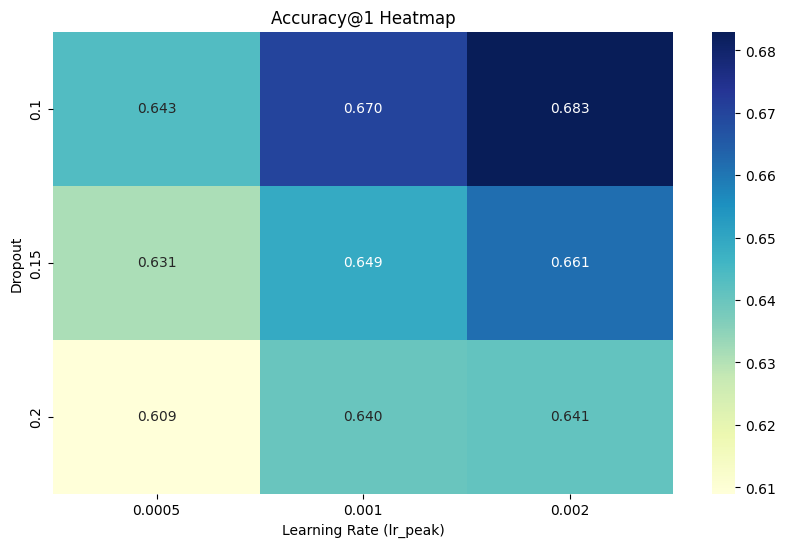

In [91]:
#Accuracy@1 по dropout и lr_peak
plt.figure(figsize=(10, 6))
pivot_df = results_df.pivot(index="dropout", columns="lr_peak", values="accuracy@1")

print(pivot_df)

#тепловая карта
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Accuracy@1 Heatmap")
plt.xlabel("Learning Rate (lr_peak)")
plt.ylabel("Dropout")
plt.show()

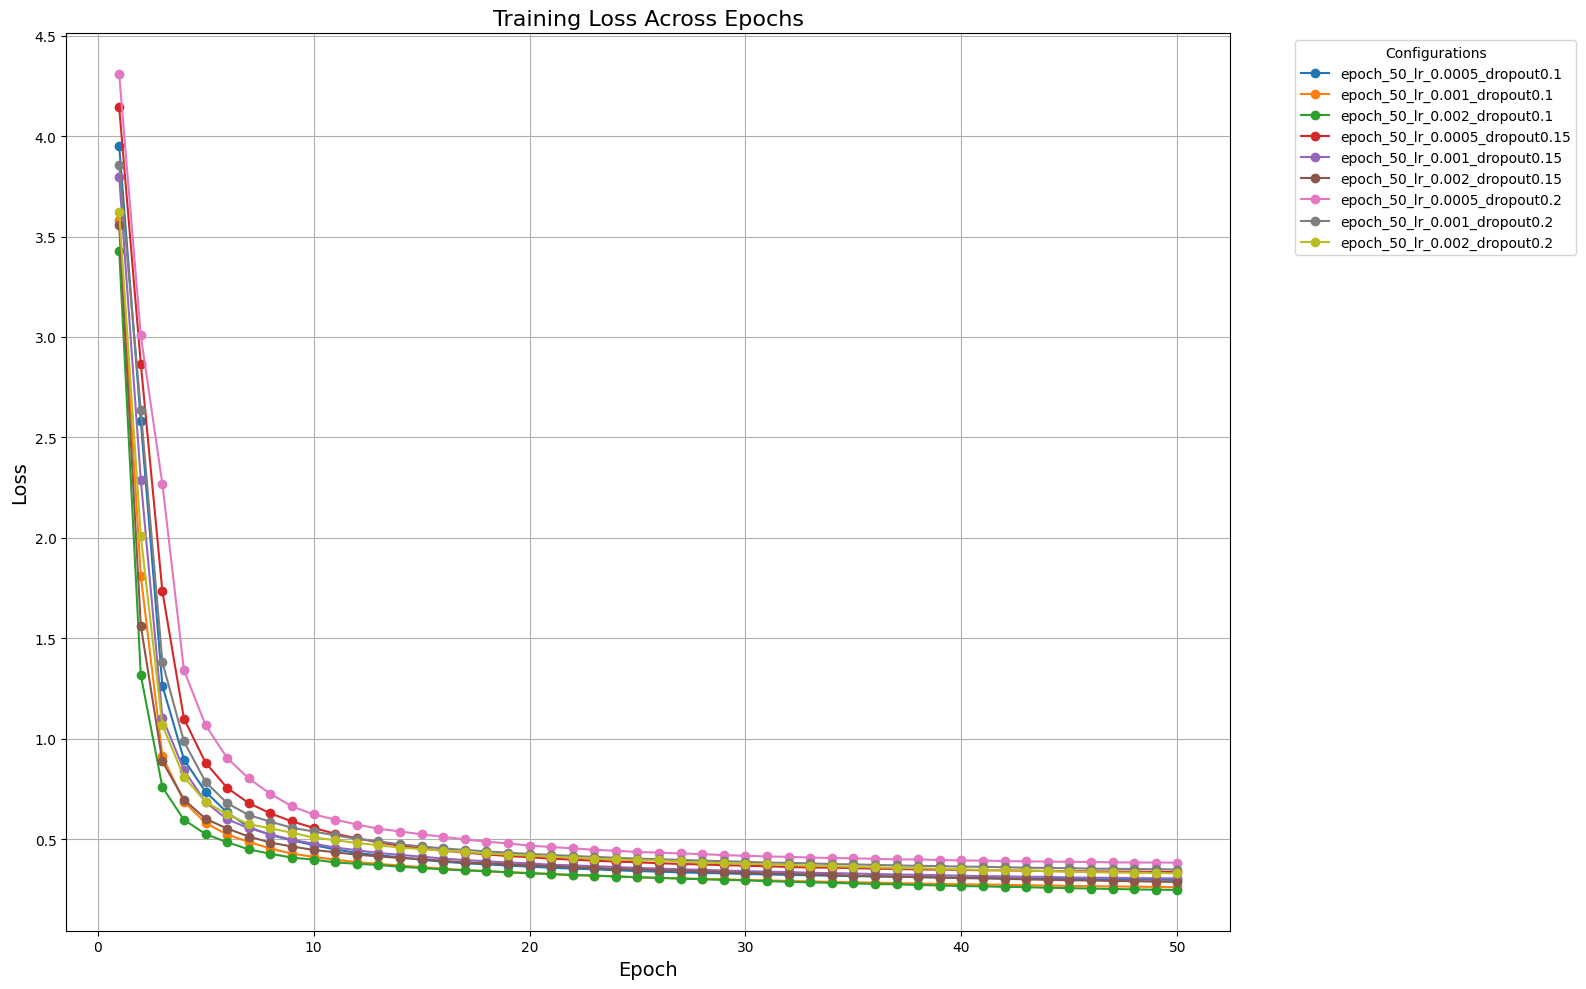

In [94]:
plt.figure(figsize=(16, 10))

for label, losses in all_losses.items():
        epochs = range(1, len(losses) + 1)  
        plt.plot(epochs, losses, marker='o', label=label) 
    
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss Across Epochs', fontsize=16)
plt.legend(title="Configurations", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout() 
plt.show()

По loss всё хорошо идёт, чего-то очень катастрафичного нет.

Порог 0.68 был пробит, но хочу выше. Попробуем запусить код на 100 эпох.

In [96]:
param_grid = {
    'dropout': [0.1, 0.15, 0.2],
    'lr_peak': [5e-4, 1e-3, 2e-3],
    'n_epochs': [100]
}

In [99]:
all_losses = {}

In [100]:
results_2 = []
for params in ParameterGrid(param_grid):

      model_config_main['dropout'] = { 
          'embedding': params['dropout'],
          'attention': params['dropout'],
          'residual': params['dropout'],
          'relu': params['dropout']
      }

      train_config_main['lr_scheduler']['lr_peak'] = params['lr_peak']
      train_config_main['n_epochs'] = params['n_epochs']

      print(f"Training with dropout={params['dropout']}, lr_peak={params['lr_peak']} and n_epochs={params['n_epochs']}")
      st = time.time()
      my_params = train(train_strings, train_transliterations, model_config_main, train_config_main)  #передаём все нужные параметры и обучаем
      print('Classifier trained in %.2fs' % (time.time() - st))

      print('\nClassifying dev_small set with %d examples ...' % len(test_strings))
      st = time.time()
      preds = classify(test_strings, my_params)
      print('Predictions generated in in %.2fs' % (time.time() - st))

      accuracy = compute_metrics(preds, test_transliterations, metrics)
      print(f"Accuracy@1: {accuracy}")

      #сохраним результаты
      results_2.append({'dropout': params['dropout'], 'lr_peak': params['lr_peak'], 'accuracy@1': accuracy['acc@1']})

Training with dropout=0.1, lr_peak=0.0005 and n_epochs=100
Using GPU device: cuda


/tmp/ipykernel_30/3721165519.py:147: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  model_config['max_src_seq_length'] = max(train_df['en'].aggregate(len)) + 2
/tmp/ipykernel_30/3721165519.py:148: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  model_config['max_tgt_seq_length'] = max(train_df['ru'].aggregate(len)) + 2


Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 4.379119 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 2.969107 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 31.55it/s]


** End of epoch, accumulated average loss = 2.319030 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 1.267108 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.963361 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.796461 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.681644 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.607917 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.560874 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.42it/s]


** End of epoch, accumulated average loss = 0.523791 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.492627 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.58it/s]


** End of epoch, accumulated average loss = 0.463651 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.42it/s]


** End of epoch, accumulated average loss = 0.440111 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.48it/s]


** End of epoch, accumulated average loss = 0.421708 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.409307 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.398575 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.73it/s]


** End of epoch, accumulated average loss = 0.386334 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.97it/s]


** End of epoch, accumulated average loss = 0.379487 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.371962 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.366317 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.360877 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.57it/s]


** End of epoch, accumulated average loss = 0.354351 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.349053 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.346902 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.75it/s]


** End of epoch, accumulated average loss = 0.341292 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 31.82it/s]


** End of epoch, accumulated average loss = 0.337682 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.334294 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 31.97it/s]


** End of epoch, accumulated average loss = 0.330827 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.327310 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 31.94it/s]


** End of epoch, accumulated average loss = 0.324565 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.321888 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.319489 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.316951 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.315163 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.312454 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.310927 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.308542 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.306752 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.92it/s]


** End of epoch, accumulated average loss = 0.304243 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.303093 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.301546 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.69it/s]


** End of epoch, accumulated average loss = 0.299775 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 31.81it/s]


** End of epoch, accumulated average loss = 0.298390 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.296432 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 31.58it/s]


** End of epoch, accumulated average loss = 0.294737 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.293868 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.292721 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.290937 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.289357 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.52it/s]


** End of epoch, accumulated average loss = 0.288355 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 51
Run training...


527it [00:16, 32.52it/s]


** End of epoch, accumulated average loss = 0.287213 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 52
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.285674 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 53
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.285480 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 54
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.283829 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 55
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.282536 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 56
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.282377 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 57
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.280291 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 58
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.280298 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 59
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.278627 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 60
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.278387 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 61
Run training...


527it [00:16, 31.85it/s]


** End of epoch, accumulated average loss = 0.277066 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 62
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 0.276218 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 63
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.275477 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 64
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.273829 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 65
Run training...


527it [00:16, 31.71it/s]


** End of epoch, accumulated average loss = 0.273580 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 66
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.272960 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 67
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.272578 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 68
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.270923 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 69
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.270124 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 70
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.269768 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 71
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.268703 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 72
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.267726 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 73
Run training...


527it [00:16, 32.48it/s]


** End of epoch, accumulated average loss = 0.267580 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 74
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.266791 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 75
Run training...


527it [00:16, 31.79it/s]


** End of epoch, accumulated average loss = 0.265876 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 76
Run training...


527it [00:16, 32.42it/s]


** End of epoch, accumulated average loss = 0.265550 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 77
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.264382 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 78
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.263987 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 79
Run training...


527it [00:16, 32.70it/s]


** End of epoch, accumulated average loss = 0.263269 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 80
Run training...


527it [00:16, 31.64it/s]


** End of epoch, accumulated average loss = 0.263290 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 81
Run training...


527it [00:16, 32.72it/s]


** End of epoch, accumulated average loss = 0.262133 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 82
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.261325 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 83
Run training...


527it [00:16, 32.48it/s]


** End of epoch, accumulated average loss = 0.261496 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 84
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.260246 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 85
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.259778 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 86
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.258652 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 87
Run training...


527it [00:16, 32.93it/s]


** End of epoch, accumulated average loss = 0.259434 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 88
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 0.258845 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 89
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.258245 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 90
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.257769 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 91
Run training...


527it [00:16, 32.78it/s]


** End of epoch, accumulated average loss = 0.257491 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 92
Run training...


527it [00:16, 31.83it/s]


** End of epoch, accumulated average loss = 0.255914 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 93
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.257065 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 94
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.255917 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 95
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.255456 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 96
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.255726 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 97
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.254494 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 98
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.254138 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 99
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.254006 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 100
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.253519 **
** Elapsed time: 0:00:16**
Classifier trained in 1635.31s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Predictions generated in in 1.56s
Accuracy@1: {'acc@1': 0.673}
Training with dropout=0.1, lr_peak=0.001 and n_epochs=100
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 3.961578 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 2.684410 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.02it/s]


** End of epoch, accumulated average loss = 1.325908 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.42it/s]


** End of epoch, accumulated average loss = 0.905489 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.749389 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.652025 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 31.76it/s]


** End of epoch, accumulated average loss = 0.580223 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.521185 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 31.80it/s]


** End of epoch, accumulated average loss = 0.488577 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.455631 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.433951 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.85it/s]


** End of epoch, accumulated average loss = 0.414745 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 31.57it/s]


** End of epoch, accumulated average loss = 0.398315 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.389099 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 31.51it/s]


** End of epoch, accumulated average loss = 0.380995 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.370450 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.362520 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.356343 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 31.94it/s]


** End of epoch, accumulated average loss = 0.350259 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.345177 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.339205 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.335957 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.330327 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.327525 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 0.324305 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 31.52it/s]


** End of epoch, accumulated average loss = 0.320564 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 0.316506 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 31.80it/s]


** End of epoch, accumulated average loss = 0.313975 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.312261 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 31.47it/s]


** End of epoch, accumulated average loss = 0.308786 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.305914 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 31.17it/s]


** End of epoch, accumulated average loss = 0.303754 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.301822 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 31.59it/s]


** End of epoch, accumulated average loss = 0.299129 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.297188 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.36it/s]


** End of epoch, accumulated average loss = 0.295280 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.293474 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.292205 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.290188 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 31.43it/s]


** End of epoch, accumulated average loss = 0.288122 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.287293 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.286247 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.02it/s]


** End of epoch, accumulated average loss = 0.284309 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.281980 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.280657 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.279250 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 31.82it/s]


** End of epoch, accumulated average loss = 0.277320 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.276440 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.275649 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.274003 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 51
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.273003 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 52
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.271378 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 53
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.270563 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 54
Run training...


527it [00:16, 32.42it/s]


** End of epoch, accumulated average loss = 0.269139 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 55
Run training...


527it [00:16, 31.80it/s]


** End of epoch, accumulated average loss = 0.268305 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 56
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.266640 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 57
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.265943 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 58
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.264661 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 59
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.264296 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 60
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.262415 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 61
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.262381 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 62
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.261052 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 63
Run training...


527it [00:16, 31.82it/s]


** End of epoch, accumulated average loss = 0.259532 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 64
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.258579 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 65
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.258030 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 66
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.256599 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 67
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.256191 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 68
Run training...


527it [00:16, 32.55it/s]


** End of epoch, accumulated average loss = 0.254631 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 69
Run training...


527it [00:16, 31.78it/s]


** End of epoch, accumulated average loss = 0.254123 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 70
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.252929 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 71
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.252144 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 72
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.251286 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 73
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.249887 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 74
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.249042 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 75
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.248234 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 76
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.247859 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 77
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.246753 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 78
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.246242 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 79
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.245318 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 80
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.244338 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 81
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.243117 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 82
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.242443 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 83
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.242034 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 84
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.241204 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 85
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.240368 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 86
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.239514 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 87
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.239294 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 88
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.238411 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 89
Run training...


527it [00:16, 31.67it/s]


** End of epoch, accumulated average loss = 0.237555 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 90
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.236533 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 91
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.236295 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 92
Run training...


527it [00:16, 32.13it/s]


** End of epoch, accumulated average loss = 0.235904 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 93
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.235062 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 94
Run training...


527it [00:16, 31.53it/s]


** End of epoch, accumulated average loss = 0.233845 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 95
Run training...


527it [00:16, 32.54it/s]


** End of epoch, accumulated average loss = 0.233609 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 96
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.233241 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 97
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.232841 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 98
Run training...


527it [00:16, 31.62it/s]


** End of epoch, accumulated average loss = 0.232073 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 99
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.231864 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 100
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.231093 **
** Elapsed time: 0:00:17**
Classifier trained in 1642.62s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Predictions generated in in 1.52s
Accuracy@1: {'acc@1': 0.684}
Training with dropout=0.1, lr_peak=0.002 and n_epochs=100
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 3.592952 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.75it/s]


** End of epoch, accumulated average loss = 1.902931 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 31.83it/s]


** End of epoch, accumulated average loss = 0.930160 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.701130 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.589624 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.531791 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 31.75it/s]


** End of epoch, accumulated average loss = 0.500447 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.471570 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.448663 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.71it/s]


** End of epoch, accumulated average loss = 0.430562 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.418011 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.407355 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.395958 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.59it/s]


** End of epoch, accumulated average loss = 0.382425 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.374097 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.367699 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.77it/s]


** End of epoch, accumulated average loss = 0.364891 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.355778 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.354216 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.70it/s]


** End of epoch, accumulated average loss = 0.346785 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 31.69it/s]


** End of epoch, accumulated average loss = 0.342680 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.338839 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.59it/s]


** End of epoch, accumulated average loss = 0.336892 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.331126 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.328160 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.325847 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.324316 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.320173 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.326997 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.315745 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.73it/s]


** End of epoch, accumulated average loss = 0.313367 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 31.77it/s]


** End of epoch, accumulated average loss = 0.311225 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.70it/s]


** End of epoch, accumulated average loss = 0.308175 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 31.81it/s]


** End of epoch, accumulated average loss = 0.306251 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.305348 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.303124 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.300697 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 31.83it/s]


** End of epoch, accumulated average loss = 0.299924 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.298347 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.296471 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.294798 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 31.48it/s]


** End of epoch, accumulated average loss = 0.292475 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.291966 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.290789 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.288090 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.286229 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.285489 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 31.76it/s]


** End of epoch, accumulated average loss = 0.283475 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.281083 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.281619 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 51
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.279561 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 52
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.278314 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 53
Run training...


527it [00:16, 32.71it/s]


** End of epoch, accumulated average loss = 0.276786 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 54
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.275960 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 55
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.275039 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 56
Run training...


527it [00:16, 32.78it/s]


** End of epoch, accumulated average loss = 0.272797 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 57
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.271875 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 58
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.270206 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 59
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.269728 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 60
Run training...


527it [00:16, 32.74it/s]


** End of epoch, accumulated average loss = 0.267590 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 61
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.266722 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 62
Run training...


527it [00:16, 32.59it/s]


** End of epoch, accumulated average loss = 0.265569 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 63
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.263825 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 64
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.262909 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 65
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.262302 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 66
Run training...


527it [00:16, 32.86it/s]


** End of epoch, accumulated average loss = 0.260480 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 67
Run training...


527it [00:16, 31.62it/s]


** End of epoch, accumulated average loss = 0.259797 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 68
Run training...


527it [00:15, 33.07it/s]


** End of epoch, accumulated average loss = 0.258238 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 69
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.257469 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 70
Run training...


527it [00:16, 32.68it/s]


** End of epoch, accumulated average loss = 0.256711 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 71
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.255266 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 72
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.253615 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 73
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.252516 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 74
Run training...


527it [00:16, 32.70it/s]


** End of epoch, accumulated average loss = 0.251266 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 75
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 0.250645 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 76
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.249409 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 77
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.248876 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 78
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.247056 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 79
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.246715 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 80
Run training...


527it [00:16, 32.81it/s]


** End of epoch, accumulated average loss = 0.245167 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 81
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.243540 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 82
Run training...


527it [00:16, 32.93it/s]


** End of epoch, accumulated average loss = 0.243522 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 83
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 0.242255 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 84
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.240965 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 85
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.240463 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 86
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.238317 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 87
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.238428 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 88
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.237143 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 89
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.236124 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 90
Run training...


527it [00:16, 32.59it/s]


** End of epoch, accumulated average loss = 0.235238 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 91
Run training...


527it [00:16, 32.78it/s]


** End of epoch, accumulated average loss = 0.234145 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 92
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.233354 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 93
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.231474 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 94
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.231334 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 95
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.230568 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 96
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.229634 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 97
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.228620 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 98
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.228461 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 99
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.227909 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 100
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.227363 **
** Elapsed time: 0:00:16**
Classifier trained in 1632.22s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


Predictions generated in in 1.50s
Accuracy@1: {'acc@1': 0.6825}
Training with dropout=0.15, lr_peak=0.0005 and n_epochs=100
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 4.304418 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 31.46it/s]


** End of epoch, accumulated average loss = 3.088100 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 2.603812 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 31.64it/s]


** End of epoch, accumulated average loss = 1.560248 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 1.148753 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.973685 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.836047 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 31.70it/s]


** End of epoch, accumulated average loss = 0.727970 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.659145 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.607747 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.574726 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.543152 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.519502 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.501216 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.483518 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.468402 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.54it/s]


** End of epoch, accumulated average loss = 0.454155 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.441127 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.432186 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.421216 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 31.67it/s]


** End of epoch, accumulated average loss = 0.414856 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.408196 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.401576 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 31.84it/s]


** End of epoch, accumulated average loss = 0.395475 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.389629 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.387004 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 31.60it/s]


** End of epoch, accumulated average loss = 0.381756 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.378583 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.06it/s]


** End of epoch, accumulated average loss = 0.372815 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.369870 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.71it/s]


** End of epoch, accumulated average loss = 0.367380 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.364428 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 31.74it/s]


** End of epoch, accumulated average loss = 0.359798 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.356880 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 31.23it/s]


** End of epoch, accumulated average loss = 0.355115 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.353344 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 31.64it/s]


** End of epoch, accumulated average loss = 0.350046 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.348849 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 31.62it/s]


** End of epoch, accumulated average loss = 0.346860 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.344763 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 31.65it/s]


** End of epoch, accumulated average loss = 0.341859 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.340026 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.06it/s]


** End of epoch, accumulated average loss = 0.338571 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 31.66it/s]


** End of epoch, accumulated average loss = 0.336701 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.335271 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 31.56it/s]


** End of epoch, accumulated average loss = 0.333671 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.332474 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.331086 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.329584 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 31.44it/s]


** End of epoch, accumulated average loss = 0.327668 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 51
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.327332 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 52
Run training...


527it [00:16, 31.63it/s]


** End of epoch, accumulated average loss = 0.325909 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 53
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.324085 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 54
Run training...


527it [00:16, 31.84it/s]


** End of epoch, accumulated average loss = 0.323418 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 55
Run training...


527it [00:16, 31.66it/s]


** End of epoch, accumulated average loss = 0.321362 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 56
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.320907 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 57
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.319473 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 58
Run training...


527it [00:16, 31.67it/s]


** End of epoch, accumulated average loss = 0.319509 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 59
Run training...


527it [00:16, 31.85it/s]


** End of epoch, accumulated average loss = 0.318223 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 60
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.316489 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 61
Run training...


527it [00:16, 31.46it/s]


** End of epoch, accumulated average loss = 0.315995 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 62
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.314267 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 63
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.314463 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 64
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.312936 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 65
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.312098 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 66
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.311512 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 67
Run training...


527it [00:16, 31.56it/s]


** End of epoch, accumulated average loss = 0.310252 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 68
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.310205 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 69
Run training...


527it [00:16, 31.80it/s]


** End of epoch, accumulated average loss = 0.308380 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 70
Run training...


527it [00:16, 32.72it/s]


** End of epoch, accumulated average loss = 0.309275 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 71
Run training...


527it [00:16, 32.49it/s]


** End of epoch, accumulated average loss = 0.307948 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 72
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.307092 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 73
Run training...


527it [00:16, 31.64it/s]


** End of epoch, accumulated average loss = 0.305296 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 74
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.305484 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 75
Run training...


527it [00:16, 31.65it/s]


** End of epoch, accumulated average loss = 0.305391 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 76
Run training...


527it [00:16, 32.82it/s]


** End of epoch, accumulated average loss = 0.304024 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 77
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.303325 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 78
Run training...


527it [00:16, 31.85it/s]


** End of epoch, accumulated average loss = 0.302371 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 79
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.302222 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 80
Run training...


527it [00:15, 32.98it/s]


** End of epoch, accumulated average loss = 0.301546 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 81
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.301400 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 82
Run training...


527it [00:16, 32.80it/s]


** End of epoch, accumulated average loss = 0.301006 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 83
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.299969 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 84
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.298986 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 85
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.298271 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 86
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.298449 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 87
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.297184 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 88
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.296723 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 89
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.296919 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 90
Run training...


527it [00:16, 32.78it/s]


** End of epoch, accumulated average loss = 0.296498 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 91
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.295585 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 92
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.295528 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 93
Run training...


527it [00:16, 32.72it/s]


** End of epoch, accumulated average loss = 0.295598 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 94
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.295218 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 95
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.294748 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 96
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.293419 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 97
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.294305 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 98
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.294166 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 99
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.292928 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 100
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.293552 **
** Elapsed time: 0:00:16**
Classifier trained in 1643.32s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Predictions generated in in 1.51s
Accuracy@1: {'acc@1': 0.65}
Training with dropout=0.15, lr_peak=0.001 and n_epochs=100
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 4.026497 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 2.832444 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 1.612408 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 31.75it/s]


** End of epoch, accumulated average loss = 1.069412 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.871439 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.750432 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.674325 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.617657 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.583029 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.546512 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.75it/s]


** End of epoch, accumulated average loss = 0.526563 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.13it/s]


** End of epoch, accumulated average loss = 0.490943 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.471289 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 31.75it/s]


** End of epoch, accumulated average loss = 0.458765 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.442878 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 31.85it/s]


** End of epoch, accumulated average loss = 0.433016 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.54it/s]


** End of epoch, accumulated average loss = 0.423102 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.414572 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.408103 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:15, 32.96it/s]


** End of epoch, accumulated average loss = 0.401064 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.397261 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.54it/s]


** End of epoch, accumulated average loss = 0.389255 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.385416 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.378703 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.375274 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.74it/s]


** End of epoch, accumulated average loss = 0.371443 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.370135 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.49it/s]


** End of epoch, accumulated average loss = 0.365879 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.361538 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.359211 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.55it/s]


** End of epoch, accumulated average loss = 0.355601 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.355145 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.350518 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.76it/s]


** End of epoch, accumulated average loss = 0.348317 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.344974 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.343487 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 31.61it/s]


** End of epoch, accumulated average loss = 0.341964 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.339939 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.34it/s]


** End of epoch, accumulated average loss = 0.337922 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.335940 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 0.334121 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.332821 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.331349 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.328844 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.327602 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.34it/s]


** End of epoch, accumulated average loss = 0.325405 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.324421 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.322800 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.321974 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 31.94it/s]


** End of epoch, accumulated average loss = 0.320104 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 51
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.318750 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 52
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.317974 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 53
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.316936 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 54
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.315597 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 55
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.313889 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 56
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.312685 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 57
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.311517 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 58
Run training...


527it [00:16, 31.59it/s]


** End of epoch, accumulated average loss = 0.311140 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 59
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.309885 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 60
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.309167 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 61
Run training...


527it [00:16, 32.48it/s]


** End of epoch, accumulated average loss = 0.307480 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 62
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.306639 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 63
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.305038 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 64
Run training...


527it [00:16, 31.81it/s]


** End of epoch, accumulated average loss = 0.303832 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 65
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.303195 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 66
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.302276 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 67
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.301635 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 68
Run training...


527it [00:16, 32.75it/s]


** End of epoch, accumulated average loss = 0.301276 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 69
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.299347 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 70
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.299137 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 71
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.297565 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 72
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.297066 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 73
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.295411 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 74
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.294491 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 75
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.293991 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 76
Run training...


527it [00:16, 32.52it/s]


** End of epoch, accumulated average loss = 0.293872 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 77
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.291978 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 78
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.291269 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 79
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.291249 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 80
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.289914 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 81
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.288611 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 82
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.288467 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 83
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.287993 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 84
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.287277 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 85
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.286519 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 86
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.286249 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 87
Run training...


527it [00:16, 31.73it/s]


** End of epoch, accumulated average loss = 0.285057 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 88
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.284417 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 89
Run training...


527it [00:16, 31.21it/s]


** End of epoch, accumulated average loss = 0.283471 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 90
Run training...


527it [00:16, 32.54it/s]


** End of epoch, accumulated average loss = 0.283083 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 91
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.281892 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 92
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.281406 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 93
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.280577 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 94
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.280329 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 95
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.279895 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 96
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.278902 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 97
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.278588 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 98
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.278475 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 99
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.277873 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 100
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.277823 **
** Elapsed time: 0:00:16**
Classifier trained in 1632.83s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


Predictions generated in in 1.49s
Accuracy@1: {'acc@1': 0.6705}
Training with dropout=0.15, lr_peak=0.002 and n_epochs=100
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 3.818422 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 2.199465 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 1.109047 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.852567 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.34it/s]


** End of epoch, accumulated average loss = 0.687627 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.608181 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.561406 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.537471 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.78it/s]


** End of epoch, accumulated average loss = 0.510285 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 31.63it/s]


** End of epoch, accumulated average loss = 0.499361 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.42it/s]


** End of epoch, accumulated average loss = 0.479559 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.458984 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.448988 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.432654 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.426499 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.416885 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.416003 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.401890 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.398555 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.392153 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.387416 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.383884 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.77it/s]


** End of epoch, accumulated average loss = 0.381004 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.375878 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.375173 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.06it/s]


** End of epoch, accumulated average loss = 0.373848 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.368603 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.364219 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.364349 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.359484 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.79it/s]


** End of epoch, accumulated average loss = 0.356397 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.354874 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 31.46it/s]


** End of epoch, accumulated average loss = 0.351517 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.350042 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 31.71it/s]


** End of epoch, accumulated average loss = 0.348040 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 32.54it/s]


** End of epoch, accumulated average loss = 0.346382 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.06it/s]


** End of epoch, accumulated average loss = 0.343776 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.341709 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.341096 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.339019 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 31.97it/s]


** End of epoch, accumulated average loss = 0.337102 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.335503 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.333420 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.332462 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.330989 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.76it/s]


** End of epoch, accumulated average loss = 0.328993 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.328091 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.85it/s]


** End of epoch, accumulated average loss = 0.326303 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 31.76it/s]


** End of epoch, accumulated average loss = 0.324797 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.322555 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 51
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.321560 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 52
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.319697 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 53
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 0.319378 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 54
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.318065 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 55
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.316872 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 56
Run training...


527it [00:16, 32.92it/s]


** End of epoch, accumulated average loss = 0.314459 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 57
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.315209 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 58
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.312556 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 59
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.311800 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 60
Run training...


527it [00:16, 32.64it/s]


** End of epoch, accumulated average loss = 0.309941 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 61
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.308494 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 62
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.307803 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 63
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.306299 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 64
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.305129 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 65
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.304474 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 66
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.303166 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 67
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.301706 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 68
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.300827 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 69
Run training...


527it [00:16, 32.78it/s]


** End of epoch, accumulated average loss = 0.300029 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 70
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.298332 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 71
Run training...


527it [00:15, 33.08it/s]


** End of epoch, accumulated average loss = 0.297366 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 72
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.296840 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 73
Run training...


527it [00:16, 32.81it/s]


** End of epoch, accumulated average loss = 0.295105 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 74
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.294540 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 75
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.293320 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 76
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 0.292176 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 77
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.290813 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 78
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 0.290200 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 79
Run training...


527it [00:16, 32.81it/s]


** End of epoch, accumulated average loss = 0.289524 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 80
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.287537 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 81
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.287186 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 82
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.286122 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 83
Run training...


527it [00:16, 32.81it/s]


** End of epoch, accumulated average loss = 0.284635 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 84
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.284103 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 85
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 0.283433 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 86
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.281501 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 87
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.280909 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 88
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.280061 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 89
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.279579 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 90
Run training...


527it [00:16, 31.84it/s]


** End of epoch, accumulated average loss = 0.278392 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 91
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.277521 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 92
Run training...


527it [00:16, 31.51it/s]


** End of epoch, accumulated average loss = 0.277050 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 93
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.275629 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 94
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.275688 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 95
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.274805 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 96
Run training...


527it [00:16, 32.68it/s]


** End of epoch, accumulated average loss = 0.273006 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 97
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.272770 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 98
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.271918 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 99
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.271504 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 100
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.271505 **
** Elapsed time: 0:00:16**
Classifier trained in 1633.81s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Predictions generated in in 1.51s
Accuracy@1: {'acc@1': 0.6665}
Training with dropout=0.2, lr_peak=0.0005 and n_epochs=100
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 4.443829 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 3.176798 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.87it/s]


** End of epoch, accumulated average loss = 2.843212 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 2.156900 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 1.404487 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.85it/s]


** End of epoch, accumulated average loss = 1.136847 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.984888 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.76it/s]


** End of epoch, accumulated average loss = 0.869342 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.77it/s]


** End of epoch, accumulated average loss = 0.770109 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.703629 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.650391 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.614716 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 31.01it/s]


** End of epoch, accumulated average loss = 0.588655 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.566141 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.547677 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 31.64it/s]


** End of epoch, accumulated average loss = 0.532149 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.518987 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.503754 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 31.77it/s]


** End of epoch, accumulated average loss = 0.491701 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.479372 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 31.56it/s]


** End of epoch, accumulated average loss = 0.469796 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 31.98it/s]


** End of epoch, accumulated average loss = 0.461305 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.74it/s]


** End of epoch, accumulated average loss = 0.454584 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 31.69it/s]


** End of epoch, accumulated average loss = 0.446981 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 31.57it/s]


** End of epoch, accumulated average loss = 0.441749 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.435376 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.430693 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 31.82it/s]


** End of epoch, accumulated average loss = 0.425411 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.421371 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 31.69it/s]


** End of epoch, accumulated average loss = 0.416329 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.413634 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 31.31it/s]


** End of epoch, accumulated average loss = 0.409314 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.405303 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.403739 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 31.79it/s]


** End of epoch, accumulated average loss = 0.399118 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.25it/s]


** End of epoch, accumulated average loss = 0.397151 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.393834 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 31.66it/s]


** End of epoch, accumulated average loss = 0.392385 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.73it/s]


** End of epoch, accumulated average loss = 0.390392 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.386569 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.384999 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 31.70it/s]


** End of epoch, accumulated average loss = 0.382605 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.380809 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.378724 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.377480 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.06it/s]


** End of epoch, accumulated average loss = 0.375911 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.375356 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 31.70it/s]


** End of epoch, accumulated average loss = 0.373148 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.370891 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.369826 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 51
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.369113 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 52
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.367021 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 53
Run training...


527it [00:16, 31.56it/s]


** End of epoch, accumulated average loss = 0.366221 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 54
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.365867 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 55
Run training...


527it [00:16, 31.85it/s]


** End of epoch, accumulated average loss = 0.364153 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 56
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.361876 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 57
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.361359 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 58
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.359643 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 59
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.358914 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 60
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.356776 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 61
Run training...


527it [00:16, 31.61it/s]


** End of epoch, accumulated average loss = 0.357134 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 62
Run training...


527it [00:16, 31.64it/s]


** End of epoch, accumulated average loss = 0.355689 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 63
Run training...


527it [00:16, 31.74it/s]


** End of epoch, accumulated average loss = 0.354941 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 64
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.353928 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 65
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.352201 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 66
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.351903 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 67
Run training...


527it [00:16, 31.62it/s]


** End of epoch, accumulated average loss = 0.351331 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 68
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.350650 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 69
Run training...


527it [00:16, 32.55it/s]


** End of epoch, accumulated average loss = 0.350132 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 70
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.348424 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 71
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.347474 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 72
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.347560 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 73
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.346503 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 74
Run training...


527it [00:16, 32.48it/s]


** End of epoch, accumulated average loss = 0.346037 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 75
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.344940 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 76
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.344882 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 77
Run training...


527it [00:16, 32.49it/s]


** End of epoch, accumulated average loss = 0.343795 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 78
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.343642 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 79
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.342246 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 80
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.341916 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 81
Run training...


527it [00:16, 31.83it/s]


** End of epoch, accumulated average loss = 0.341589 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 82
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.341256 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 83
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.339635 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 84
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.339999 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 85
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.338433 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 86
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.338594 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 87
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.337851 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 88
Run training...


527it [00:16, 31.83it/s]


** End of epoch, accumulated average loss = 0.337477 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 89
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.337067 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 90
Run training...


527it [00:16, 31.05it/s]


** End of epoch, accumulated average loss = 0.336482 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 91
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.335713 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 92
Run training...


527it [00:16, 31.32it/s]


** End of epoch, accumulated average loss = 0.336186 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 93
Run training...


527it [00:16, 31.59it/s]


** End of epoch, accumulated average loss = 0.335517 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 94
Run training...


527it [00:16, 31.76it/s]


** End of epoch, accumulated average loss = 0.334370 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 95
Run training...


527it [00:16, 31.77it/s]


** End of epoch, accumulated average loss = 0.334782 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 96
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.334311 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 97
Run training...


527it [00:16, 31.76it/s]


** End of epoch, accumulated average loss = 0.333830 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 98
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 0.332551 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 99
Run training...


527it [00:16, 32.13it/s]


** End of epoch, accumulated average loss = 0.332559 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 100
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.333400 **
** Elapsed time: 0:00:16**
Classifier trained in 1646.20s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


Predictions generated in in 1.49s
Accuracy@1: {'acc@1': 0.6445}
Training with dropout=0.2, lr_peak=0.001 and n_epochs=100
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 4.127893 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 2.990754 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 2.408307 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 1.370379 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 1.054691 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.901266 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 31.59it/s]


** End of epoch, accumulated average loss = 0.792279 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.701130 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.638854 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.599422 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.566800 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.68it/s]


** End of epoch, accumulated average loss = 0.541991 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 31.63it/s]


** End of epoch, accumulated average loss = 0.522715 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.52it/s]


** End of epoch, accumulated average loss = 0.505154 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 31.83it/s]


** End of epoch, accumulated average loss = 0.486552 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.474897 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.64it/s]


** End of epoch, accumulated average loss = 0.464034 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.453166 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.446924 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.438867 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.432555 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.426329 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.421280 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.416173 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.83it/s]


** End of epoch, accumulated average loss = 0.413398 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.408618 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.405224 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.402022 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.400006 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.397089 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.394200 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.390802 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.388443 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.386920 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.383550 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.74it/s]


** End of epoch, accumulated average loss = 0.381639 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.379917 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 31.55it/s]


** End of epoch, accumulated average loss = 0.377723 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.93it/s]


** End of epoch, accumulated average loss = 0.375474 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.68it/s]


** End of epoch, accumulated average loss = 0.374178 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.373024 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.370700 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.64it/s]


** End of epoch, accumulated average loss = 0.370114 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 31.81it/s]


** End of epoch, accumulated average loss = 0.367485 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.365466 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.55it/s]


** End of epoch, accumulated average loss = 0.363988 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.362681 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.362266 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.359590 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.358549 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 51
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.357867 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 52
Run training...


527it [00:16, 32.75it/s]


** End of epoch, accumulated average loss = 0.356675 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 53
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.354020 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 54
Run training...


527it [00:16, 32.85it/s]


** End of epoch, accumulated average loss = 0.354149 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 55
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.352746 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 56
Run training...


527it [00:16, 32.83it/s]


** End of epoch, accumulated average loss = 0.351360 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 57
Run training...


527it [00:16, 31.93it/s]


** End of epoch, accumulated average loss = 0.349876 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 58
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 0.349185 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 59
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.348047 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 60
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.346474 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 61
Run training...


527it [00:16, 31.53it/s]


** End of epoch, accumulated average loss = 0.345129 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 62
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.344801 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 63
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.344126 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 64
Run training...


527it [00:16, 32.49it/s]


** End of epoch, accumulated average loss = 0.343236 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 65
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.341877 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 66
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.340588 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 67
Run training...


527it [00:16, 31.80it/s]


** End of epoch, accumulated average loss = 0.340083 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 68
Run training...


527it [00:16, 32.92it/s]


** End of epoch, accumulated average loss = 0.338189 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 69
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.338087 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 70
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.336554 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 71
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.336818 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 72
Run training...


527it [00:16, 32.89it/s]


** End of epoch, accumulated average loss = 0.334835 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 73
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.335140 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 74
Run training...


527it [00:16, 32.46it/s]


** End of epoch, accumulated average loss = 0.333168 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 75
Run training...


527it [00:16, 31.70it/s]


** End of epoch, accumulated average loss = 0.333094 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 76
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.331550 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 77
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.331020 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 78
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.330225 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 79
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.329309 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 80
Run training...


527it [00:16, 32.77it/s]


** End of epoch, accumulated average loss = 0.329024 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 81
Run training...


527it [00:16, 31.47it/s]


** End of epoch, accumulated average loss = 0.328358 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 82
Run training...


527it [00:16, 32.34it/s]


** End of epoch, accumulated average loss = 0.327671 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 83
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.327067 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 84
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.325574 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 85
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.325429 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 86
Run training...


527it [00:16, 32.37it/s]


** End of epoch, accumulated average loss = 0.323830 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 87
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.323520 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 88
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.322731 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 89
Run training...


527it [00:15, 32.95it/s]


** End of epoch, accumulated average loss = 0.322229 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 90
Run training...


527it [00:16, 31.59it/s]


** End of epoch, accumulated average loss = 0.321855 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 91
Run training...


527it [00:16, 32.88it/s]


** End of epoch, accumulated average loss = 0.320685 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 92
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.320686 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 93
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.319804 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 94
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.319270 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 95
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.319358 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 96
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.318038 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 97
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.318086 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 98
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.317015 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 99
Run training...


527it [00:16, 32.64it/s]


** End of epoch, accumulated average loss = 0.317660 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 100
Run training...


527it [00:16, 31.63it/s]


** End of epoch, accumulated average loss = 0.317111 **
** Elapsed time: 0:00:17**
Classifier trained in 1633.25s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


Predictions generated in in 1.52s
Accuracy@1: {'acc@1': 0.6485}
Training with dropout=0.2, lr_peak=0.002 and n_epochs=100
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 3.961700 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 31.56it/s]


** End of epoch, accumulated average loss = 2.572004 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.41it/s]


** End of epoch, accumulated average loss = 1.347246 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 0.993618 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.807092 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.694690 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.634758 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.57it/s]


** End of epoch, accumulated average loss = 0.597764 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.574868 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 31.31it/s]


** End of epoch, accumulated average loss = 0.554046 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 31.48it/s]


** End of epoch, accumulated average loss = 0.536442 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.512141 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 31.35it/s]


** End of epoch, accumulated average loss = 0.492555 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.481641 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 31.65it/s]


** End of epoch, accumulated average loss = 0.470351 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.464165 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.455859 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.09it/s]


** End of epoch, accumulated average loss = 0.450407 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 31.20it/s]


** End of epoch, accumulated average loss = 0.444472 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.439303 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.432555 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.427004 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.34it/s]


** End of epoch, accumulated average loss = 0.425732 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.418629 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.416919 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.415208 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.413540 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.406022 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.404429 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 31.33it/s]


** End of epoch, accumulated average loss = 0.400846 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 0.397762 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.396417 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 31.82it/s]


** End of epoch, accumulated average loss = 0.395506 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.71it/s]


** End of epoch, accumulated average loss = 0.392831 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.35it/s]


** End of epoch, accumulated average loss = 0.390929 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.77it/s]


** End of epoch, accumulated average loss = 0.387348 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.77it/s]


** End of epoch, accumulated average loss = 0.384831 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.48it/s]


** End of epoch, accumulated average loss = 0.381941 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.381355 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.379705 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.378189 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.69it/s]


** End of epoch, accumulated average loss = 0.377609 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.373578 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.58it/s]


** End of epoch, accumulated average loss = 0.372790 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.70it/s]


** End of epoch, accumulated average loss = 0.371683 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.369175 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.367904 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.57it/s]


** End of epoch, accumulated average loss = 0.365897 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.61it/s]


** End of epoch, accumulated average loss = 0.365943 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.363572 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 51
Run training...


527it [00:16, 31.77it/s]


** End of epoch, accumulated average loss = 0.360656 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 52
Run training...


527it [00:16, 32.54it/s]


** End of epoch, accumulated average loss = 0.360377 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 53
Run training...


527it [00:16, 31.77it/s]


** End of epoch, accumulated average loss = 0.357853 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 54
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 0.357423 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 55
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.355674 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 56
Run training...


527it [00:16, 31.47it/s]


** End of epoch, accumulated average loss = 0.354399 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 57
Run training...


527it [00:16, 32.59it/s]


** End of epoch, accumulated average loss = 0.353891 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 58
Run training...


527it [00:16, 32.71it/s]


** End of epoch, accumulated average loss = 0.352129 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 59
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.350236 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 60
Run training...


527it [00:16, 31.47it/s]


** End of epoch, accumulated average loss = 0.349148 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 61
Run training...


527it [00:16, 31.47it/s]


** End of epoch, accumulated average loss = 0.347670 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 62
Run training...


527it [00:16, 32.06it/s]


** End of epoch, accumulated average loss = 0.346884 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 63
Run training...


527it [00:16, 32.67it/s]


** End of epoch, accumulated average loss = 0.345457 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 64
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.344472 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 65
Run training...


527it [00:16, 32.56it/s]


** End of epoch, accumulated average loss = 0.342288 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 66
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.341486 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 67
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.339243 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 68
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.339559 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 69
Run training...


527it [00:16, 32.57it/s]


** End of epoch, accumulated average loss = 0.338062 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 70
Run training...


527it [00:16, 31.87it/s]


** End of epoch, accumulated average loss = 0.338196 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 71
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.335798 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 72
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.335166 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 73
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.333613 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 74
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.332077 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 75
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.330526 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 76
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.329737 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 77
Run training...


527it [00:16, 32.87it/s]


** End of epoch, accumulated average loss = 0.328854 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 78
Run training...


527it [00:16, 31.85it/s]


** End of epoch, accumulated average loss = 0.327951 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 79
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.325807 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 80
Run training...


527it [00:16, 32.65it/s]


** End of epoch, accumulated average loss = 0.325482 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 81
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.324372 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 82
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.323844 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 83
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.321825 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 84
Run training...


527it [00:16, 32.53it/s]


** End of epoch, accumulated average loss = 0.321956 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 85
Run training...


527it [00:16, 32.87it/s]


** End of epoch, accumulated average loss = 0.320452 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 86
Run training...


527it [00:16, 32.85it/s]


** End of epoch, accumulated average loss = 0.318868 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 87
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.319008 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 88
Run training...


527it [00:16, 32.69it/s]


** End of epoch, accumulated average loss = 0.316996 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 89
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.316330 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 90
Run training...


527it [00:16, 32.16it/s]


** End of epoch, accumulated average loss = 0.315235 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 91
Run training...


527it [00:16, 32.43it/s]


** End of epoch, accumulated average loss = 0.314881 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 92
Run training...


527it [00:16, 32.83it/s]


** End of epoch, accumulated average loss = 0.314012 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 93
Run training...


527it [00:16, 31.97it/s]


** End of epoch, accumulated average loss = 0.312752 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 94
Run training...


527it [00:16, 32.52it/s]


** End of epoch, accumulated average loss = 0.312074 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 95
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.311759 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 96
Run training...


527it [00:16, 32.55it/s]


** End of epoch, accumulated average loss = 0.310731 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 97
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.309064 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 98
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.308673 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 99
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.308554 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 100
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.307721 **
** Elapsed time: 0:00:16**
Classifier trained in 1636.73s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]

Predictions generated in in 1.52s
Accuracy@1: {'acc@1': 0.6495}


In [101]:
results_2

[{'dropout': 0.1, 'lr_peak': 0.0005, 'accuracy@1': 0.673},
 {'dropout': 0.1, 'lr_peak': 0.001, 'accuracy@1': 0.684},
 {'dropout': 0.1, 'lr_peak': 0.002, 'accuracy@1': 0.6825},
 {'dropout': 0.15, 'lr_peak': 0.0005, 'accuracy@1': 0.65},
 {'dropout': 0.15, 'lr_peak': 0.001, 'accuracy@1': 0.6705},
 {'dropout': 0.15, 'lr_peak': 0.002, 'accuracy@1': 0.6665},
 {'dropout': 0.2, 'lr_peak': 0.0005, 'accuracy@1': 0.6445},
 {'dropout': 0.2, 'lr_peak': 0.001, 'accuracy@1': 0.6485},
 {'dropout': 0.2, 'lr_peak': 0.002, 'accuracy@1': 0.6495}]

In [102]:
with open("parameters_100_epochs.json", "w", encoding="utf-8") as file:
    json.dump(results_2, file)

In [103]:
results_df_2 = pd.DataFrame(results_2).sort_values(by='accuracy@1', ascending=False)
print("Best Hyperparameters 100 epochs:")
print(results_df_2.head(1))

Best Hyperparameters 100 epochs:
   dropout  lr_peak  accuracy@1
1      0.1    0.001       0.684


lr_peak  0.0005  0.0010  0.0020
dropout                        
0.10     0.6730  0.6840  0.6825
0.15     0.6500  0.6705  0.6665
0.20     0.6445  0.6485  0.6495


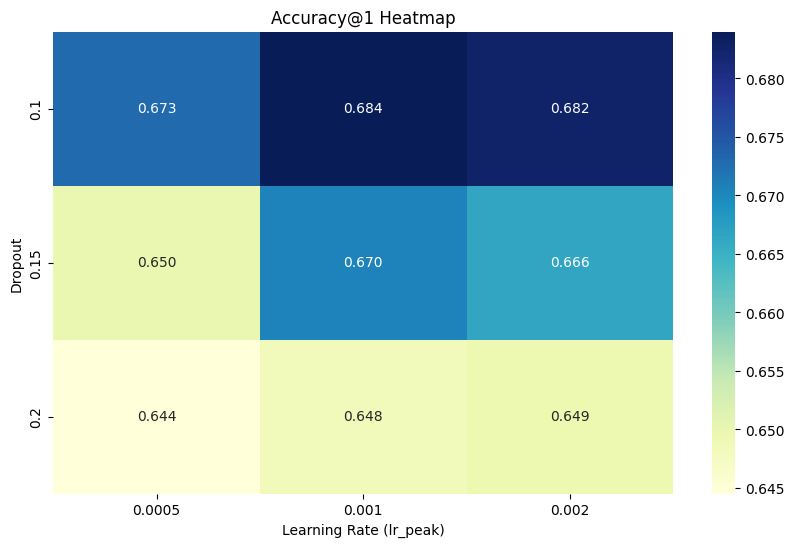

In [104]:
plt.figure(figsize=(10, 6))
pivot_df_2 = results_df_2.pivot(index="dropout", columns="lr_peak", values="accuracy@1")

print(pivot_df_2)

#тепловая карта
sns.heatmap(pivot_df_2, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Accuracy@1 Heatmap")
plt.xlabel("Learning Rate (lr_peak)")
plt.ylabel("Dropout")
plt.show()

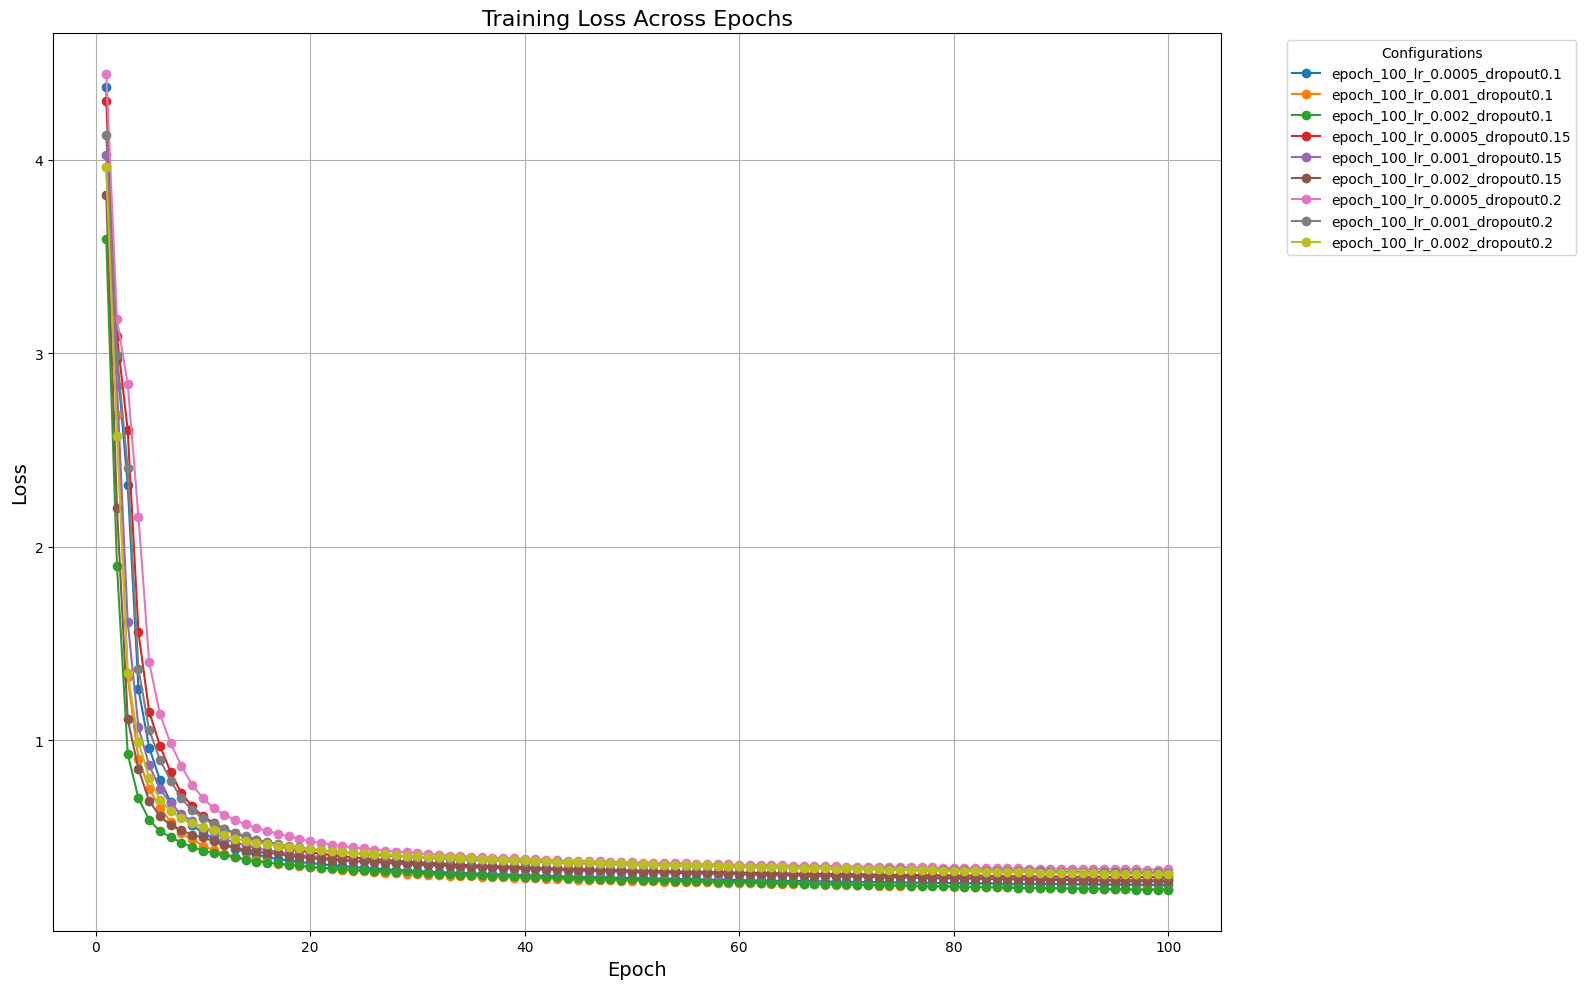

In [105]:
plt.figure(figsize=(16, 10))

for label, losses in all_losses.items():
        epochs = range(1, len(losses) + 1)  
        plt.plot(epochs, losses, marker='o', label=label) 
    
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss Across Epochs', fontsize=16)
plt.legend(title="Configurations", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout() 
plt.show()

По loss всё хорошо, в целом.

Результат не очень сильно увеличился. Разница буквально в 0,001. По параметрам на 50 эпохах:  dropout = 0.1,  lr_peak = 0.002. На 100 эпохах: dropout = 0.1, lr_peak = 0.001. При этом во втором случае обучение было около 4х часов. 

По лучшим параметрам получается dropout = 0.1, lr_peak = 0.001 и 100 эпох.

## Label smoothing [1 Point]

Now imagine that we have a prediction vector from probabilities at position t in the sequence of tokens for each token id from the vocabulary. CrossEntropy compares it with ground truth one-hot representation



$$[0, ... 0, 1, 0, ..., 0].$$



And now imagine that we are slightly "smoothed" the values in the ground truth vector and obtained



$$[\frac{\alpha}{|V|}, ..., \frac{\alpha}{|V|}, 1(1-\alpha)+\frac{\alpha}{|V|},  \frac{\alpha}{|V|}, ... \frac{\alpha}{|V|}],$$



where $\alpha$ - parameter from 0 to 1, $|V|$ - vocabulary size - number of components in the ground truth vector. The values ​​of this new vector are still summed to 1. Calculate the cross-entropy of our prediction vector and the new ground truth. Now, firstly, cross-entropy will never reach 0, and secondly, the result of the error function will require the model, as usual, to return the highest probability vector compared to other components of the probability vector for the correct token in the dictionary, but at the same time not too large, because as the value of this probability approaches 1, the value of the error function increases. For research on the use of label smoothing, see the [paper](https://arxiv.org/abs/1906.02629).

    

Accordingly, in order to embed label smoothing into the model, it is necessary to carry out the transformation described above on the ground truth vectors, as well as to implement the cross-entropy calculation, since the used `torch.nn.CrossEntropy` class is not quite suitable, since for the ground truth representation of `__call__` method takes the id of the correct token and builds a one-hot vector already inside. However, it is possible to implement what is required based on the internal implementation of this class [CrossEntropyLoss](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html#CrossEntropyLoss).

    



Test different values of $\alpha$ (e.x, 0.05, 0.1, 0.2). Describe your experiments and results.


```



ENTER HERE YOUR ANSWER



```

Тут реализую LabelSmoothing

In [108]:
# ENTER HERE YOUR CODE

class LabelSmoothingCrossEntropyLoss(torch.nn.Module):
    def __init__(self, alpha, vocab_size):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.alpha = alpha
        self.vocab_size = vocab_size

    def forward(self, logits, target):
        log_proba = F.log_softmax(logits, dim=-1) #нужен log_softmax с log, так как этого требует cross emtropy
        
        with torch.no_grad(): #отключаю гражиент
            true_proba = torch.full_like(log_proba, self.alpha / self.vocab_size) #нужен тензор с основными значениями
            indexes = torch.arange(log_proba.size(0)) #последовательность индексов
            true_proba[indexes, target] = 1 - self.alpha + self.alpha / self.vocab_size #для правильных токенов поменяем значение           
        
        loss = -torch.sum(true_proba * log_proba, dim=-1).mean()
        return loss

Надо переписать функцию train и run_epoch

In [109]:
def run_epoch(data_iter, model, lr_scheduler, optimizer, device, verbose=False, alpha=0.1):
    start = time.time()
    local_start = start
    total_tokens = 0
    total_loss = 0
    tokens = 0
    # TODO: TAKE CROSS ENTROPY LOSS WITH SUM REDUCTION
    loss_fn = LabelSmoothingCrossEntropyLoss(alpha=alpha, vocab_size=model.config['tgt_vocab_size'])
    for i, batch in tqdm(enumerate(data_iter)):
        encoder_input = batch[0].to(device)
        decoder_input = batch[1].to(device)
        decoder_target = batch[2].to(device)
        # TODO: OBTAIN MODEL LOGITS, PASS THEM TO LOSS_FN AND CALCULATE LOSS
        logits = model(encoder_input, decoder_input)
        loss = loss_fn(logits.view(-1, logits.size(-1)), decoder_target.view(-1))
        #возьмём logits, размерность подправим и возьмём соответствующие метки
        total_loss += loss.item()
        batch_n_tokens = (decoder_target != model.pad_idx).sum().item()
        total_tokens += batch_n_tokens
        if optimizer is not None:
            optimizer.zero_grad()
            lr_scheduler.step(optimizer)
            loss.backward()
            optimizer.step()

        tokens += batch_n_tokens
        if verbose and i % 1000 == 1:
            elapsed = time.time() - local_start
            print("batch number: %d, accumulated average loss: %f, tokens per second: %f" %
                  (i, total_loss / total_tokens, tokens / elapsed))
            local_start = time.time()
            tokens = 0

    average_loss = total_loss / total_tokens
    print('** End of epoch, accumulated average loss = %f **' % average_loss)
    epoch_elapsed_time = format_time(time.time() - start)
    print(f'** Elapsed time: {epoch_elapsed_time}**')
    return average_loss

def train(source_strings, target_strings, model_config=None, train_config=None, alpha=0.1, all_losses={}):
    '''Common training cycle for final run (fixed hyperparameters,
    no evaluation during training)'''
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Using GPU device: {device}')

    else:
        device = torch.device('cpu')
        print(f'GPU is not available, using CPU device {device}')

    train_df = pd.DataFrame({'en': source_strings, 'ru': target_strings})
    text_encoder = TextEncoder()
    text_encoder.make_vocabs(train_df)

    # TODO: MOVE CONFIG TO ARGUMENTS
    if model_config is None: #если model_config не передали
      model_config = {
          'src_vocab_size': text_encoder.src_vocab_size,
          'tgt_vocab_size': text_encoder.tgt_vocab_size,
          'max_src_seq_length': max(train_df['en'].aggregate(len)) + 2, 
          'max_tgt_seq_length': max(train_df['ru'].aggregate(len)) + 2,
          'n_layers': 2,
          'n_heads': 2,
          'hidden_size': 128,
          'ff_hidden_size': 256,
          'dropout': {
              'embedding': 0.1,
              'attention': 0.1,
              'residual': 0.1,
              'relu': 0.1
          },
          'pad_idx': 0
      }

    else: #поскольку здесь находится text_encoder, чтобы его ещё и вне добавлять
          #сделала вот так, добавляя необходимые значения к тому, что передадим в функцию
      model_config['src_vocab_size'] = text_encoder.src_vocab_size
      model_config['tgt_vocab_size'] = text_encoder.tgt_vocab_size
      model_config['max_src_seq_length'] = max(train_df['en'].aggregate(len)) + 2
      model_config['max_tgt_seq_length'] = max(train_df['ru'].aggregate(len)) + 2

    model = prepare_model(model_config)
    model.to(device)

    # TODO: MOVE CONFIG TO ARGUMENTS
    if train_config is None: #если train_config не передали
      train_config = {'batch_size': 200, 'n_epochs': 1, 'lr_scheduler': {
          'type': 'warmup,decay_linear',
          'warmup_steps_part': 0.1,
          'lr_peak': 3e-4,
      }}


    #Model training procedure
    optimizer = torch.optim.Adam(model.parameters(), lr=0.)
    n_steps = (len(train_df) // train_config['batch_size'] + 1) * train_config['n_epochs']
    lr_scheduler = LrScheduler(n_steps, **train_config['lr_scheduler'])

    # prepare train data
    source_strings, target_strings = zip(*sorted(zip(source_strings, target_strings),
                                                 key=lambda e: len(e[0])))
    train_dataloader = create_dataloader(source_strings, target_strings, text_encoder,
                                         train_config['batch_size'],
                                         shuffle_batches_each_epoch=True)

    epoch_losses = []
    # training cycle
    for epoch in range(1,train_config['n_epochs']+1):
        print('\n' + '-'*40)
        print(f'Epoch: {epoch}')
        print(f'Run training...')
        model.train()
        average_loss = run_epoch(train_dataloader, model,
                  lr_scheduler, optimizer, device=device, verbose=False, alpha=alpha)
        epoch_losses.append(average_loss)

    def train(source_strings, target_strings, model_config=None, train_config=None, all_losses={}):
    '''Common training cycle for final run (fixed hyperparameters,
    no evaluation during training)'''
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Using GPU device: {device}')

    else:
        device = torch.device('cpu')
        print(f'GPU is not available, using CPU device {device}')

    train_df = pd.DataFrame({'en': source_strings, 'ru': target_strings})
    text_encoder = TextEncoder()
    text_encoder.make_vocabs(train_df)

    # TODO: MOVE CONFIG TO ARGUMENTS
    if model_config is None: #если model_config не передали
      model_config = {
          'src_vocab_size': text_encoder.src_vocab_size,
          'tgt_vocab_size': text_encoder.tgt_vocab_size,
          'max_src_seq_length': max(train_df['en'].aggregate(len)) + 2, 
          'max_tgt_seq_length': max(train_df['ru'].aggregate(len)) + 2,
          'n_layers': 2,
          'n_heads': 2,
          'hidden_size': 128,
          'ff_hidden_size': 256,
          'dropout': {
              'embedding': 0.1,
              'attention': 0.1,
              'residual': 0.1,
              'relu': 0.1
          },
          'pad_idx': 0
      }

    else: #поскольку здесь находится text_encoder, чтобы его ещё и вне добавлять
          #сделала вот так, добавляя необходимые значения к тому, что передадим в функцию
      model_config['src_vocab_size'] = text_encoder.src_vocab_size
      model_config['tgt_vocab_size'] = text_encoder.tgt_vocab_size
      model_config['max_src_seq_length'] = max(train_df['en'].aggregate(len)) + 2
      model_config['max_tgt_seq_length'] = max(train_df['ru'].aggregate(len)) + 2

    model = prepare_model(model_config)
    model.to(device)

    # TODO: MOVE CONFIG TO ARGUMENTS
    if train_config is None: #если train_config не передали
      train_config = {'batch_size': 200, 'n_epochs': 1, 'lr_scheduler': {
          'type': 'warmup,decay_linear',
          'warmup_steps_part': 0.1,
          'lr_peak': 3e-4,
      }}


    #Model training procedure
    optimizer = torch.optim.Adam(model.parameters(), lr=0.)
    n_steps = (len(train_df) // train_config['batch_size'] + 1) * train_config['n_epochs']
    lr_scheduler = LrScheduler(n_steps, **train_config['lr_scheduler'])

    # prepare train data
    source_strings, target_strings = zip(*sorted(zip(source_strings, target_strings),
                                                 key=lambda e: len(e[0])))
    train_dataloader = create_dataloader(source_strings, target_strings, text_encoder,
                                         train_config['batch_size'],
                                         shuffle_batches_each_epoch=True)
    
    epoch_losses = [] #loss по эпохам
    # training cycle
    for epoch in range(1,train_config['n_epochs']+1):
        print('\n' + '-'*40)
        print(f'Epoch: {epoch}')
        print(f'Run training...')
        model.train()
        average_loss = run_epoch(train_dataloader, model,
                  lr_scheduler, optimizer, device=device, verbose=False)
        epoch_losses.append(average_loss)  #сохраняем loss для текущей эпохи

    all_losses[f"epoch_{train_config['n_epochs']}_lr_{train_config['lr_scheduler']['lr_peak']}_dropout{model_config_main['dropout']['embedding']}_alpha_{alpha}"] = epoch_losses
    
    learnable_params = {
        'model': model,
        'text_encoder': text_encoder
    }
    return learnable_params
    
    learnable_params = {
        'model': model,
        'text_encoder': text_encoder
    }
    return learnable_params

IndentationError: expected an indented block after function definition on line 117 (2480334473.py, line 118)

In [110]:
all_losses = {}

Посмотрю на 50 эпохах с лучшими параметрами.

In [111]:
param_grid = {
    'dropout': [0.1],
    'lr_peak': [2e-3],
    'n_epochs': [50],
    'alpha': [0.05, 0.1, 0.2]
}

In [112]:
results_3 = []
for params in ParameterGrid(param_grid):

      model_config_main['dropout'] = { 
          'embedding': params['dropout'],
          'attention': params['dropout'],
          'residual': params['dropout'],
          'relu': params['dropout']
      }

      train_config_main['lr_scheduler']['lr_peak'] = params['lr_peak']
      train_config_main['n_epochs'] = params['n_epochs']

      print(f"Training with dropout={params['dropout']}, lr_peak={params['lr_peak']}, alpha={params['alpha']} and n_epochs={params['n_epochs']}")
      st = time.time()
      my_params = train(train_strings, train_transliterations, model_config_main, train_config_main, params['alpha'])  #передаём все нужные параметры и обучаем
      print('Classifier trained in %.2fs' % (time.time() - st))

      print('\nClassifying dev_small set with %d examples ...' % len(test_strings))
      st = time.time()
      preds = classify(test_strings, my_params)
      print('Predictions generated in in %.2fs' % (time.time() - st))

      accuracy = compute_metrics(preds, test_transliterations, metrics)
      print(f"Accuracy@1: {accuracy}")

      #сохраним результаты
      results_3.append({'dropout': params['dropout'], 'lr_peak': params['lr_peak'], 'alpha': params['alpha'], 'accuracy@1': accuracy['acc@1']})

Training with dropout=0.1, lr_peak=0.002, alpha=0.05 and n_epochs=50
Using GPU device: cuda


/tmp/ipykernel_30/3721165519.py:147: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  model_config['max_src_seq_length'] = max(train_df['en'].aggregate(len)) + 2
/tmp/ipykernel_30/3721165519.py:148: FutureWarning: using <built-in function len> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  model_config['max_tgt_seq_length'] = max(train_df['ru'].aggregate(len)) + 2


Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 3.318796 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 1.201178 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.713389 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 31.79it/s]


** End of epoch, accumulated average loss = 0.573897 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 31.60it/s]


** End of epoch, accumulated average loss = 0.520597 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.51it/s]


** End of epoch, accumulated average loss = 0.481521 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 31.89it/s]


** End of epoch, accumulated average loss = 0.451687 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.92it/s]


** End of epoch, accumulated average loss = 0.429271 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.409551 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.399356 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.386076 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.80it/s]


** End of epoch, accumulated average loss = 0.379987 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.04it/s]


** End of epoch, accumulated average loss = 0.374192 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.362366 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.361048 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 31.91it/s]


** End of epoch, accumulated average loss = 0.351211 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.344866 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.339841 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 31.49it/s]


** End of epoch, accumulated average loss = 0.337698 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.330452 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.326829 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.322051 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.318052 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.314196 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.311732 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.307604 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 31.97it/s]


** End of epoch, accumulated average loss = 0.304501 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 0.300835 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.298837 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.295311 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.13it/s]


** End of epoch, accumulated average loss = 0.291575 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 0.289881 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.285821 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.283893 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 31.92it/s]


** End of epoch, accumulated average loss = 0.281541 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.74it/s]


** End of epoch, accumulated average loss = 0.278948 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.276438 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 31.73it/s]


** End of epoch, accumulated average loss = 0.273562 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.27it/s]


** End of epoch, accumulated average loss = 0.271330 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.269209 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 31.94it/s]


** End of epoch, accumulated average loss = 0.266461 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.264612 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.49it/s]


** End of epoch, accumulated average loss = 0.261455 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 31.44it/s]


** End of epoch, accumulated average loss = 0.259210 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.257793 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.59it/s]


** End of epoch, accumulated average loss = 0.255822 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.253750 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.251736 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 31.75it/s]


** End of epoch, accumulated average loss = 0.249992 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.248980 **
** Elapsed time: 0:00:17**
Classifier trained in 821.25s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


Predictions generated in in 1.51s
Accuracy@1: {'acc@1': 0.669}
Training with dropout=0.1, lr_peak=0.002, alpha=0.1 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.19it/s]


** End of epoch, accumulated average loss = 3.332680 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.32it/s]


** End of epoch, accumulated average loss = 1.195141 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.747233 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 32.10it/s]


** End of epoch, accumulated average loss = 0.589986 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.532394 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.482129 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.451315 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.78it/s]


** End of epoch, accumulated average loss = 0.429728 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 31.86it/s]


** End of epoch, accumulated average loss = 0.414786 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 32.77it/s]


** End of epoch, accumulated average loss = 0.404559 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 32.45it/s]


** End of epoch, accumulated average loss = 0.393773 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.18it/s]


** End of epoch, accumulated average loss = 0.383265 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.71it/s]


** End of epoch, accumulated average loss = 0.372623 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 32.55it/s]


** End of epoch, accumulated average loss = 0.366957 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.359332 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.57it/s]


** End of epoch, accumulated average loss = 0.353112 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.347617 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.341989 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.28it/s]


** End of epoch, accumulated average loss = 0.337297 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 32.40it/s]


** End of epoch, accumulated average loss = 0.331869 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.08it/s]


** End of epoch, accumulated average loss = 0.327664 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.36it/s]


** End of epoch, accumulated average loss = 0.322965 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 32.02it/s]


** End of epoch, accumulated average loss = 0.318686 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.50it/s]


** End of epoch, accumulated average loss = 0.315920 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 32.44it/s]


** End of epoch, accumulated average loss = 0.312615 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.11it/s]


** End of epoch, accumulated average loss = 0.309281 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.305797 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.302478 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.15it/s]


** End of epoch, accumulated average loss = 0.299000 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.14it/s]


** End of epoch, accumulated average loss = 0.295893 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.293275 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 31.53it/s]


** End of epoch, accumulated average loss = 0.290413 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.287214 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 0.285145 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.282040 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.279944 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 32.24it/s]


** End of epoch, accumulated average loss = 0.277122 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 31.65it/s]


** End of epoch, accumulated average loss = 0.274618 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.272262 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 32.05it/s]


** End of epoch, accumulated average loss = 0.269747 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.80it/s]


** End of epoch, accumulated average loss = 0.267668 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.29it/s]


** End of epoch, accumulated average loss = 0.265678 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.00it/s]


** End of epoch, accumulated average loss = 0.263563 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.92it/s]


** End of epoch, accumulated average loss = 0.260839 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.22it/s]


** End of epoch, accumulated average loss = 0.259582 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.257456 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 31.97it/s]


** End of epoch, accumulated average loss = 0.254583 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 32.59it/s]


** End of epoch, accumulated average loss = 0.252510 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 31.26it/s]


** End of epoch, accumulated average loss = 0.251541 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.249801 **
** Elapsed time: 0:00:16**
Classifier trained in 818.01s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


Predictions generated in in 1.51s
Accuracy@1: {'acc@1': 0.6805}
Training with dropout=0.1, lr_peak=0.002, alpha=0.2 and n_epochs=50
Using GPU device: cuda
Batches collected: 527

----------------------------------------
Epoch: 1
Run training...


527it [00:16, 32.26it/s]


** End of epoch, accumulated average loss = 3.412090 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 2
Run training...


527it [00:16, 32.17it/s]


** End of epoch, accumulated average loss = 1.234871 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 3
Run training...


527it [00:16, 31.44it/s]


** End of epoch, accumulated average loss = 0.751803 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 4
Run training...


527it [00:16, 31.97it/s]


** End of epoch, accumulated average loss = 0.590579 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 5
Run training...


527it [00:16, 32.01it/s]


** End of epoch, accumulated average loss = 0.527155 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 6
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.484395 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 7
Run training...


527it [00:16, 32.20it/s]


** End of epoch, accumulated average loss = 0.458257 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 8
Run training...


527it [00:16, 32.06it/s]


** End of epoch, accumulated average loss = 0.427086 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 9
Run training...


527it [00:16, 31.47it/s]


** End of epoch, accumulated average loss = 0.411338 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 10
Run training...


527it [00:16, 31.96it/s]


** End of epoch, accumulated average loss = 0.396892 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 11
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.393992 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 12
Run training...


527it [00:16, 32.31it/s]


** End of epoch, accumulated average loss = 0.379420 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 13
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.372568 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 14
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.366082 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 15
Run training...


527it [00:16, 32.25it/s]


** End of epoch, accumulated average loss = 0.360781 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 16
Run training...


527it [00:16, 32.30it/s]


** End of epoch, accumulated average loss = 0.352947 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 17
Run training...


527it [00:16, 31.65it/s]


** End of epoch, accumulated average loss = 0.346578 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 18
Run training...


527it [00:16, 31.90it/s]


** End of epoch, accumulated average loss = 0.343185 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 19
Run training...


527it [00:16, 32.12it/s]


** End of epoch, accumulated average loss = 0.338015 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 20
Run training...


527it [00:16, 31.66it/s]


** End of epoch, accumulated average loss = 0.332359 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 21
Run training...


527it [00:16, 32.47it/s]


** End of epoch, accumulated average loss = 0.327801 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 22
Run training...


527it [00:16, 32.54it/s]


** End of epoch, accumulated average loss = 0.324097 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 23
Run training...


527it [00:16, 31.68it/s]


** End of epoch, accumulated average loss = 0.320561 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 24
Run training...


527it [00:16, 32.62it/s]


** End of epoch, accumulated average loss = 0.316708 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 25
Run training...


527it [00:16, 31.59it/s]


** End of epoch, accumulated average loss = 0.313740 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 26
Run training...


527it [00:16, 32.34it/s]


** End of epoch, accumulated average loss = 0.308242 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 27
Run training...


527it [00:16, 32.07it/s]


** End of epoch, accumulated average loss = 0.306551 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 28
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.302035 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 29
Run training...


527it [00:16, 32.39it/s]


** End of epoch, accumulated average loss = 0.298981 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 30
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.296390 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 31
Run training...


527it [00:16, 31.50it/s]


** End of epoch, accumulated average loss = 0.293496 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 32
Run training...


527it [00:16, 32.34it/s]


** End of epoch, accumulated average loss = 0.290699 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 33
Run training...


527it [00:16, 31.84it/s]


** End of epoch, accumulated average loss = 0.288031 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 34
Run training...


527it [00:16, 31.99it/s]


** End of epoch, accumulated average loss = 0.284637 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 35
Run training...


527it [00:16, 31.16it/s]


** End of epoch, accumulated average loss = 0.283053 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 36
Run training...


527it [00:16, 31.95it/s]


** End of epoch, accumulated average loss = 0.279494 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 37
Run training...


527it [00:16, 31.54it/s]


** End of epoch, accumulated average loss = 0.277100 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 38
Run training...


527it [00:16, 32.34it/s]


** End of epoch, accumulated average loss = 0.275088 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 39
Run training...


527it [00:16, 32.03it/s]


** End of epoch, accumulated average loss = 0.271773 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 40
Run training...


527it [00:16, 31.88it/s]


** End of epoch, accumulated average loss = 0.269698 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 41
Run training...


527it [00:16, 32.63it/s]


** End of epoch, accumulated average loss = 0.267512 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 42
Run training...


527it [00:16, 32.23it/s]


** End of epoch, accumulated average loss = 0.265732 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 43
Run training...


527it [00:16, 32.21it/s]


** End of epoch, accumulated average loss = 0.263323 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 44
Run training...


527it [00:16, 32.66it/s]


** End of epoch, accumulated average loss = 0.261682 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 45
Run training...


527it [00:16, 32.33it/s]


** End of epoch, accumulated average loss = 0.258422 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 46
Run training...


527it [00:16, 32.48it/s]


** End of epoch, accumulated average loss = 0.257098 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 47
Run training...


527it [00:16, 32.60it/s]


** End of epoch, accumulated average loss = 0.255657 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 48
Run training...


527it [00:16, 31.72it/s]


** End of epoch, accumulated average loss = 0.252830 **
** Elapsed time: 0:00:17**

----------------------------------------
Epoch: 49
Run training...


527it [00:16, 32.70it/s]


** End of epoch, accumulated average loss = 0.251272 **
** Elapsed time: 0:00:16**

----------------------------------------
Epoch: 50
Run training...


527it [00:16, 32.38it/s]


** End of epoch, accumulated average loss = 0.250051 **
** Elapsed time: 0:00:16**
Classifier trained in 822.27s

Classifying dev_small set with 2000 examples ...
Using GPU device: cuda
Batches collected: 10


100%|██████████| 10/10 [00:01<00:00,  6.60it/s]

Predictions generated in in 1.52s
Accuracy@1: {'acc@1': 0.6685}


In [113]:
results_3

[{'dropout': 0.1, 'lr_peak': 0.002, 'alpha': 0.05, 'accuracy@1': 0.669},
 {'dropout': 0.1, 'lr_peak': 0.002, 'alpha': 0.1, 'accuracy@1': 0.6805},
 {'dropout': 0.1, 'lr_peak': 0.002, 'alpha': 0.2, 'accuracy@1': 0.6685}]

In [114]:
with open("parameters_50_epochs_and_alpha.json", "w", encoding="utf-8") as file:
    json.dump(results_3, file)

Best Hyperparameters 50 epochs and alpha:
   dropout  lr_peak  alpha  accuracy@1
1      0.1    0.002    0.1      0.6805
alpha     0.05    0.10    0.20
dropout                       
0.1      0.669  0.6805  0.6685


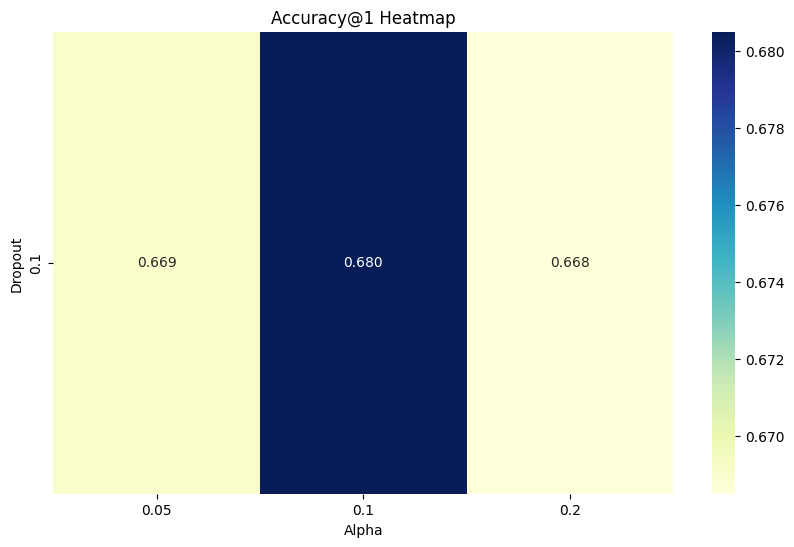

In [115]:
results_df_3 = pd.DataFrame(results_3).sort_values(by='accuracy@1', ascending=False)
print("Best Hyperparameters 50 epochs and alpha:")
print(results_df_3.head(1))

plt.figure(figsize=(10, 6))
pivot_df_3 = results_df_3.pivot(index="dropout", columns="alpha", values="accuracy@1")

print(pivot_df_3)

#тепловая карта
sns.heatmap(pivot_df_3, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Accuracy@1 Heatmap")
plt.xlabel("Alpha")
plt.ylabel("Dropout")
plt.show()

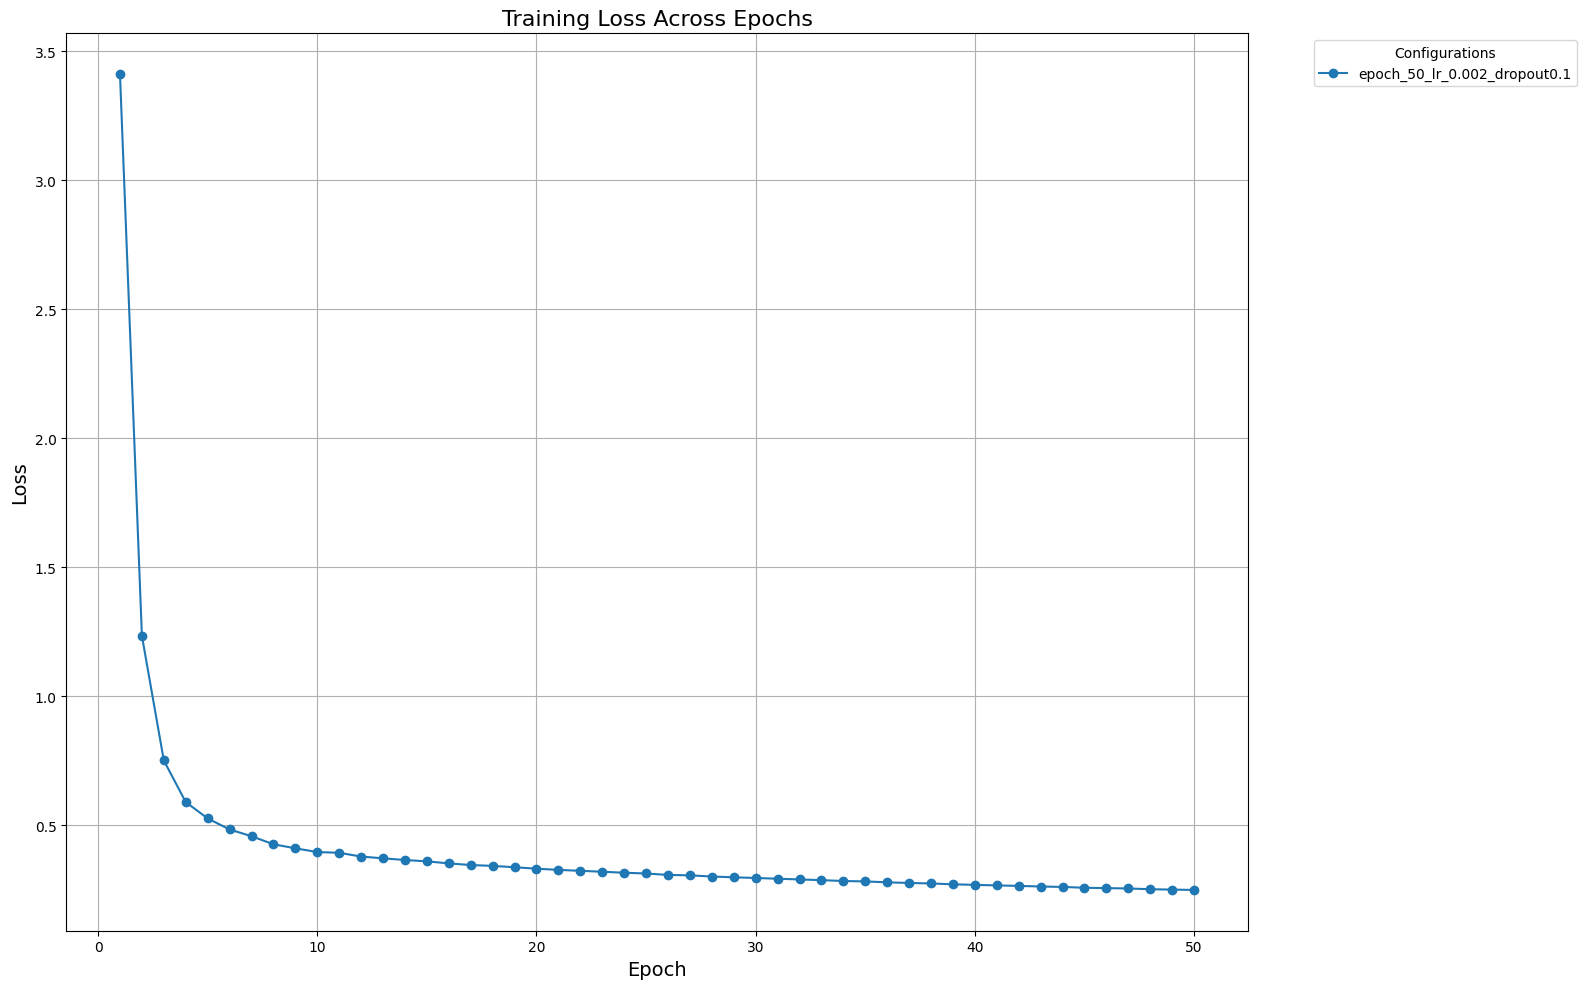

In [116]:
plt.figure(figsize=(16, 10))

for label, losses in all_losses.items():
        epochs = range(1, len(losses) + 1)  
        plt.plot(epochs, losses, marker='o', label=label) 
    
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss Across Epochs', fontsize=16)
plt.legend(title="Configurations", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout() 
plt.show()

Значение упало. Было 0.683, а теперь 0.68. Значение чуть хуже, но всё равно в пределах нормального по изменению, как мне кажется. 

Лучший результат достигается при альфе равной 0.2

# BONUS: Additional Experiments [Up to 2 Points]



Be creative and run additional experiments with changing Transformer Architecture to get better score. You probably would like to dive into



1) Reading papers



2) Play with Normalization



3) Play with Positional Encoding



4) Try different Schedulers



5) Maybe you would like to alter architecture a lot :)



The fair and interesting experiments will be highly rewarded even if the result was not successful. Nevertheless, you need to report them properly